In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [3]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [4]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


In [5]:
time_values = ds.time.values

Extract time values and units

In [6]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [7]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [8]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [9]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [10]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [11]:
ds = ds.drop_vars('time_index')

In [12]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [13]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [14]:
# Set time as the index
ds = ds.set_index(time='time')

In [15]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [16]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [17]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [18]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [19]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [20]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [21]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [22]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [23]:
df_flat.head(10)

time        lat      lon  precipitation
0 1949-01-01  49.760941 -125.625            NaN
1 1949-01-01  49.760941 -125.000            NaN
2 1949-01-01  49.760941 -124.375            NaN
3 1949-01-01  49.760941 -123.750            NaN
4 1949-01-01  49.760941 -123.125            NaN
5 1949-01-01  49.760941 -122.500            NaN
6 1949-01-01  49.760941 -121.875            NaN
7 1949-01-01  49.760941 -121.250            NaN
8 1949-01-01  49.760941 -120.625            NaN
9 1949-01-01  49.760941 -120.000            NaN

## Handle missing value in data

In [24]:
df_flat['precipitation']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
4569867    23.900000
4569868    25.800001
4569869     7.400000
4569870          NaN
4569871          NaN
Name: precipitation, Length: 4569872, dtype: float32

In [25]:
df_flat['precipitation'].isnull().sum()

1439154

In [26]:
precipitation_zero = df_flat[df_flat['precipitation'] == 0]
print(precipitation_zero)

              time        lat      lon  precipitation
42      1949-01-01  48.808578 -119.375            0.0
43      1949-01-01  48.808578 -118.750            0.0
58      1949-01-01  48.332401 -119.375            0.0
59      1949-01-01  48.332401 -118.750            0.0
73      1949-01-01  47.856220 -120.000            0.0
...            ...        ...      ...            ...
4569860 1994-12-31  42.142059 -123.125            0.0
4569861 1994-12-31  42.142059 -122.500            0.0
4569864 1994-12-31  42.142059 -120.625            0.0
4569865 1994-12-31  42.142059 -120.000            0.0
4569866 1994-12-31  42.142059 -119.375            0.0

[1800839 rows x 4 columns]


In [27]:
# Drop rows with NaN values in 'precipitation' column
df_clean = df_flat.dropna(subset=['precipitation'])

In [28]:
# Interpolate missing values
df_clean['precipitation'] = df_clean['precipitation'].interpolate(method='linear')

C:\Users\User\AppData\Local\Temp\ipykernel_23000\974457112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['precipitation'] = df_clean['precipitation'].interpolate(method='linear')


In [29]:
precipitation_zero = df_clean[df_clean['precipitation'] == 0]
print(precipitation_zero)

              time        lat      lon  precipitation
42      1949-01-01  48.808578 -119.375            0.0
43      1949-01-01  48.808578 -118.750            0.0
58      1949-01-01  48.332401 -119.375            0.0
59      1949-01-01  48.332401 -118.750            0.0
73      1949-01-01  47.856220 -120.000            0.0
...            ...        ...      ...            ...
4569860 1994-12-31  42.142059 -123.125            0.0
4569861 1994-12-31  42.142059 -122.500            0.0
4569864 1994-12-31  42.142059 -120.625            0.0
4569865 1994-12-31  42.142059 -120.000            0.0
4569866 1994-12-31  42.142059 -119.375            0.0

[1800839 rows x 4 columns]


In [30]:
# Check for remaining NaN values
print(df_clean['precipitation'].isnull().sum())

0


Filling with 0

In [31]:
# df_flat['precipitation'].fillna(0, inplace=True)

Resample

In [32]:
df_flatten = df_flat.copy()

In [33]:
# # Convert 'time' column to datetime format if it's not already
# df_flatten['time'] = pd.to_datetime(df_flatten['time'])

# # Set 'time' column as the index
# df_flatten.set_index(['time'], inplace=True)

In [34]:
# # Resample to monthly frequency and calculate the mean precipitation
# monthly_mean_precipitation = df_flatten['precipitation'].resample('M').mean()

# # Resample to weekly frequency and calculate the sum precipitation
# weekly_sum_precipitation = df_flatten['precipitation'].resample('W').sum()

Spatial Interpolation

In [35]:
df_flatten = df_flat.copy()

IDW

In [36]:
from scipy.interpolate import Rbf

# Define a function for IDW interpolation
def idw_interpolation(df, time, lat, lon):
    # Filter data for the specific time point
    df_time = df[df['time'] == time]
    
    # Filter out NaN values and create arrays for lat, lon, and precipitation
    lat_known = df_time['lat'][~df_time['precipitation'].isnull()].values
    lon_known = df_time['lon'][~df_time['precipitation'].isnull()].values
    prec_known = df_time['precipitation'][~df_time['precipitation'].isnull()].values
    
    # Perform IDW interpolation
    rbfi = Rbf(lon_known, lat_known, prec_known, function='linear')
    interp_prec = rbfi(lon, lat)
    
    return interp_prec

In [38]:
# # Find indices of NaN values in the 'precipitation' column
# nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# # Fill NaN values using IDW interpolation
# for idx in nan_indices:
#     time = df_flatten.loc[idx, 'time']
#     lat = df_flatten.loc[idx, 'lat']
#     lon = df_flatten.loc[idx, 'lon']
#     interpolated_prec = idw_interpolation(df_flatten, time, lat, lon)
#     df_flatten.loc[idx, 'precipitation'] = interpolated_prec


Kriging

In [39]:
from pykrige.ok import OrdinaryKriging

In [53]:
def kriging_interpolation(df, time, lat, lon):
    # Filter data to include only non-NaN values
    df_filtered = df.dropna(subset=['precipitation'])
    
    # Extract coordinates and values
    X = df_filtered[['lon', 'lat', 'time']].values
    values = df_filtered['precipitation'].values
    
    # Perform kriging interpolation
    OK = OrdinaryKriging(
        X[:, 0], X[:, 1], values,
        variogram_model='linear', # Specify the variogram model here
        verbose=False, enable_plotting=False
    )
    interpolated_prec, _ = OK.execute('points', lon, lat, time)
    
    # Update the 'precipitation' value in the DataFrame
    df.loc[df['time'] == time, 'precipitation'] = interpolated_prec
    
    return df


Nearest Neighbour

In [61]:
from scipy.spatial import cKDTree

# Convert 'time' column to Unix timestamps (seconds since the Unix epoch)
df_flatten['time_unix'] = df_flatten['time'].astype(np.int64) // 10**9

# Find indices of NaN values in the 'precipitation' column
nan_indices = df_flatten[df_flatten['precipitation'].isnull()].index

# Filter out rows with NaN values
df_filtered = df_flatten.dropna(subset=['lon', 'lat', 'time_unix', 'precipitation'])

# KDTree for nearest neighbor search
tree = cKDTree(df_filtered[['lon', 'lat', 'time_unix']].values)

# Batch size
batch_size = 1000

# Process NaN values in batches
for i in range(0, len(nan_indices), batch_size):
    batch_indices = nan_indices[i:i+batch_size]
    for idx in batch_indices:
        time = df_flatten.loc[idx, 'time_unix']
        lat = df_flatten.loc[idx, 'lat']
        lon = df_flatten.loc[idx, 'lon']
    
        # Find the nearest neighbor
        _, ind = tree.query([lon, lat, time], k=1)
        if isinstance(ind, int):  # Convert to list if it's an integer
            ind = [ind]
        neighbor_idx = df_filtered.iloc[ind[0]].name
    
        # Interpolate the missing value using the neighbor's value
        df_flatten.loc[idx, 'precipitation'] = df_filtered.loc[neighbor_idx, 'precipitation']

    # Print progress
    batches_completed = (i + batch_size) // batch_size
    batches_left = (len(nan_indices) + batch_size - 1) // batch_size - batches_completed
    print(f"Processed {batches_completed}/{len(nan_indices) // batch_size} batches. {batches_left} batches left.")

print("Remaining NaN count:", df_flatten['precipitation'].isnull().sum())

Processed 1/1432 batches. 1432 batches left.
Processed 2/1432 batches. 1431 batches left.
Processed 3/1432 batches. 1430 batches left.
Processed 4/1432 batches. 1429 batches left.
Processed 5/1432 batches. 1428 batches left.
Processed 6/1432 batches. 1427 batches left.
Processed 7/1432 batches. 1426 batches left.
Processed 8/1432 batches. 1425 batches left.
Processed 9/1432 batches. 1424 batches left.
Processed 10/1432 batches. 1423 batches left.
Processed 11/1432 batches. 1422 batches left.
Processed 12/1432 batches. 1421 batches left.
Processed 13/1432 batches. 1420 batches left.
Processed 14/1432 batches. 1419 batches left.
Processed 15/1432 batches. 1418 batches left.
Processed 16/1432 batches. 1417 batches left.
Processed 17/1432 batches. 1416 batches left.
Processed 18/1432 batches. 1415 batches left.
Processed 19/1432 batches. 1414 batches left.
Processed 20/1432 batches. 1413 batches left.
Processed 21/1432 batches. 1412 batches left.
Processed 22/1432 batches. 1411 batches lef

In [63]:
df_flatten['precipitation'].isnull().sum()

0

In [62]:
if df_flatten['precipitation'].isnull().sum() == 0:
    print("All NaN values filled successfully.")
else:
    print("Some NaN values remain after interpolation.")

All NaN values filled successfully.


In [65]:
df_flatten.to_csv('nn_filled_precipitation.csv')

Check duplicated rows

In [259]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


In [68]:
df_flatten = df_flatten.drop('time_unix', axis=1)

In [69]:
df_flat = df_flatten

Get ranges

In [70]:
min_date = df_flat['time'].min()
max_date = df_flat['time'].max()

print(f"The dataset covers from {min_date} to {max_date}.")

The dataset covers from 1949-01-01 00:00:00 to 1994-12-31 00:00:00.


In [71]:
# latitude
min_lat = df_flat['lat'].min()
max_lat = df_flat['lat'].max()

# longitude
min_lon = df_flat['lon'].min()
max_lon = df_flat['lon'].max()

print(f"The latitude range of the dataset is from {min_lat} to {max_lat}.")
print(f"The longitude range of the dataset is from {min_lon} to {max_lon}.")

The latitude range of the dataset is from 42.142059326171875 to 49.76094055175781.
The longitude range of the dataset is from -125.625 to -116.25.


## Features

In [72]:
df_flat['month'] = df_flat['time'].dt.month
df_flat['year'] = df_flat['time'].dt.year

Temporal Features

In [73]:
df_flat['day_of_year'] = df_flat['time'].dt.dayofyear
df_flat['week_of_year'] = df_flat['time'].dt.isocalendar().week
df_flat['day_of_week'] = df_flat['time'].dt.dayofweek

In [74]:
df_flat.size

41128848

In [75]:
df_flat.head(10)

time        lat      lon  precipitation  month  year  day_of_year  \
0 1949-01-01  49.760941 -125.625      12.451237      1  1949            1   
1 1949-01-01  49.760941 -125.000      10.839300      1  1949            1   
2 1949-01-01  49.760941 -124.375       9.390542      1  1949            1   
3 1949-01-01  49.760941 -123.750       7.837927      1  1949            1   
4 1949-01-01  49.760941 -123.125       6.168290      1  1949            1   
5 1949-01-01  49.760941 -122.500       5.225479      1  1949            1   
6 1949-01-01  49.760941 -121.875       5.853119      1  1949            1   
7 1949-01-01  49.760941 -121.250       6.569632      1  1949            1   
8 1949-01-01  49.760941 -120.625       4.984128      1  1949            1   
9 1949-01-01  49.760941 -120.000       3.096929      1  1949            1   

   week_of_year  day_of_week  
0            53            5  
1            53            5  
2            53            5  
3            53            5  
4            53            5  
5            53            5  
6            53            5  
7            53            5  
8            53            5  
9            53            5

In [266]:
# df_flat.to_csv('precipitation_data.csv', index=False)

In [76]:
grouped_by_area = df_flat.groupby(['lat', 'lon'])

Check Non zero

In [77]:
len(df_flat)

4569872

In [78]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [79]:
non_zero_precipitation_count

2120818

In [80]:
df_non_zero = df_flat[df_flat['precipitation'] > 0.0]

In [81]:
len(df_non_zero)

2119611

# Visualization

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

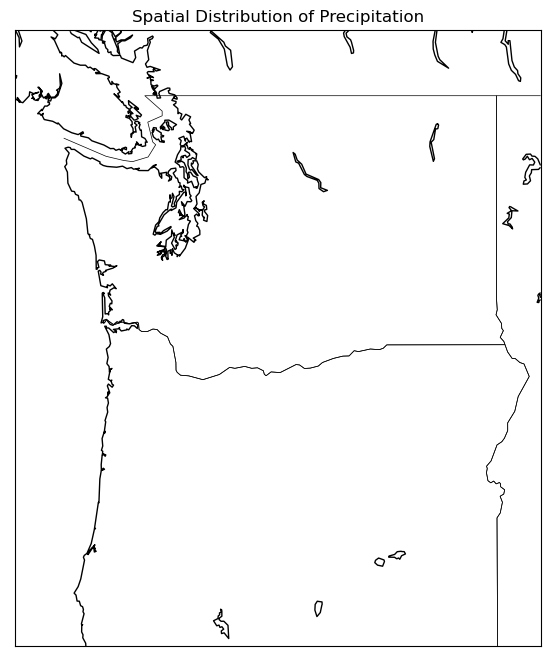

In [83]:
# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

plt.title('Spatial Distribution of Precipitation')
plt.show()

### Functions

In [84]:
def filter_data(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[(df['precipitation'] > 0) &
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [85]:
def filter_data_with_zero(df, min_lon, max_lon, min_lat, max_lat):
    """
    Filters the DataFrame for non-zero precipitation and within the specified bounds.

    Parameters:
    - df: pandas DataFrame containing the dataset
    - min_lon, max_lon: Minimum and maximum longitude of the bounding box
    - min_lat, max_lat: Minimum and maximum latitude of the bounding box

    Returns:
    - A pandas DataFrame filtered according to the specified parameters
    """
    filtered_df = df[
              (df['lon'] >= min_lon) & (df['lon'] <= max_lon) &
              (df['lat'] >= min_lat) & (df['lat'] <= max_lat)]

    return filtered_df.copy()

In [86]:
def filter_data_within_range(df, central_lat, central_lon, lat_range, lon_range):
    """
    Selects data within a specified range around a central latitude and longitude.

    Parameters:
    - df: pandas DataFrame to filter.
    - central_lat: Central latitude of the target area.
    - central_lon: Central longitude of the target area.
    - lat_range: Latitude range (extent) around the central latitude.
    - lon_range: Longitude range (extent) around the central longitude.

    Returns:
    - A pandas DataFrame containing only the data within the specified range.
    """
    min_lat = central_lat - lat_range / 2
    max_lat = central_lat + lat_range / 2
    min_lon = central_lon - lon_range / 2
    max_lon = central_lon + lon_range / 2

    filtered_df = df[(df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
                     (df['lon'] >= min_lon) & (df['lon'] <= max_lon)]
    return filtered_df

In [87]:
central_lat = 47.0
central_lon = -122.0
lat_range = 3.0
lon_range = 3.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [88]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -123.125 to -120.625
Data points latitude range: 45.951499938964844 to 48.332401275634766


In [89]:
def calculate_average_precipitation(df):
    """
    Groups the DataFrame by latitude and longitude and calculates the mean precipitation.

    Parameters:
    - df: pandas DataFrame with the filtered dataset

    Returns:
    - A pandas DataFrame with the mean precipitation for each group
    """
    return df.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

In [90]:
def plot_precipitation_heatmap(grouped_data, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data.

    Parameters:
    - grouped_data: pandas DataFrame with average precipitation data
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')
    else:
        print("No data available to plot.")

    print(f"Data points longitude range: {grouped_data['lon'].min()} to {grouped_data['lon'].max()}")
    print(f"Data points latitude range: {grouped_data['lat'].min()} to {grouped_data['lat'].max()}")

    if extent:
        print(f"Setting extent to: {extent}")
        # Set the extent using the set_extent method
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        # ax.set_xlim(extent[0], extent[1])
        # ax.set_ylim(extent[2], extent[3])
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Data points longitude range: -125.625 to -116.25
Data points latitude range: 42.142059326171875 to 49.76094055175781
Auto-adjusting extent based on data.


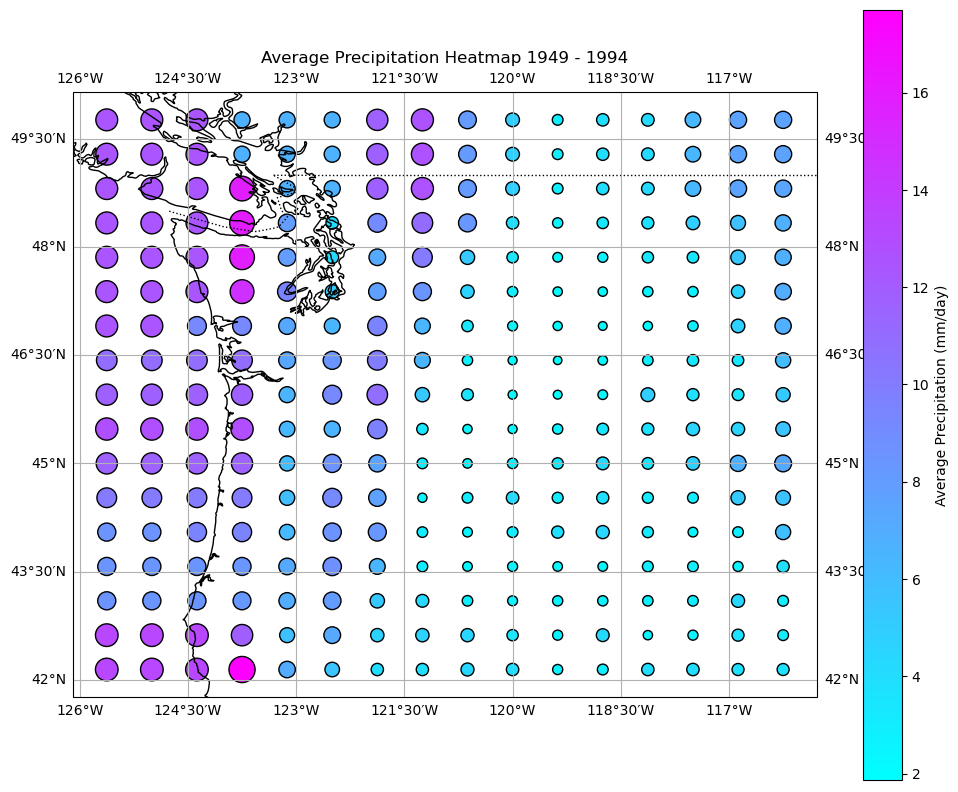

In [91]:
# Group by latitude and longitude to calculate the mean precipitation
grouped_data = calculate_average_precipitation(df_non_zero)

plot_title = 'Average Precipitation Heatmap 1949 - 1994'
plot_precipitation_heatmap(grouped_data, plot_title)

In [92]:
# The bounds of the area to zoom into
min_lon, max_lon = -123, -121
min_lat, max_lat = 46, 48

In [93]:
# Filter data within the specified area.
filtered_df = filter_data(df_non_zero, min_lon, max_lon, min_lat, max_lat)

# Calculate the average precipitation
average_precip = calculate_average_precipitation(filtered_df)

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768096923828 to 47.85622024536133
Setting extent to: (-123, -121, 46, 48)


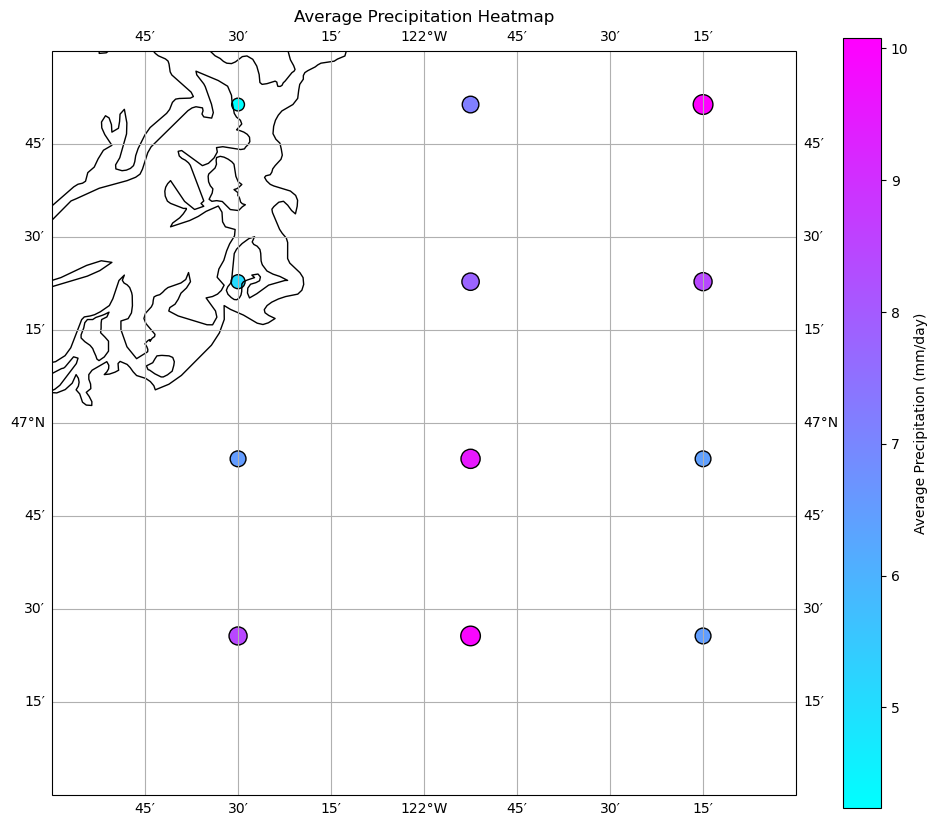

In [94]:
# Plot the results with a specified extent
plot_title = 'Average Precipitation Heatmap'
plot_precipitation_heatmap(average_precip, plot_title, extent=(min_lon, max_lon, min_lat, max_lat))

In [285]:
# df_filtered = df_non_zero

# # Group by latitude and longitude to calculate the mean precipitation
# grouped = df_filtered.groupby(['lat', 'lon'])['precipitation'].mean().reset_index()

# # Create a figure with an projection
# fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# if not grouped.empty:
#     # Scatter plot for average precipitation
#     sc = ax.scatter(grouped['lon'], grouped['lat'], c=grouped['precipitation'],
#                     cmap='cool', s=150, edgecolor='black', linewidth=1,
#                     transform=ccrs.PlateCarree())  # Ensure the transform is correct
#     plt.colorbar(sc, label='Average Precipitation (mm/day)')
# else:
#     print("No non-zero precipitation data available to plot.")

# # Set the geographic extent to encompass all points or focus on a particular region
# # ax.set_extent([min longitude, max longitude, min latitude, max latitude], crs=ccrs.PlateCarree())
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.title('Average Precipitation Heatmap 1949 - 1994')
# plt.show()

Plot specific area

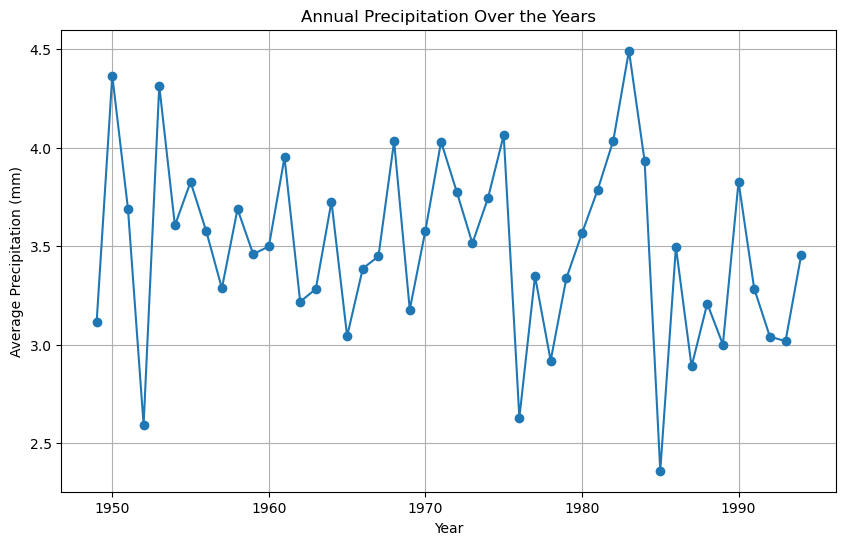

In [96]:
average_precipitation_df = df_flat.groupby('year')['precipitation'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_df['year'], average_precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Annual Precipitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True)
plt.show()

In [287]:
central_lat = 46.0
central_lon = -123.0
lat_range = 1.0
lon_range = 1.0

selected_data = filter_data_within_range(df_flat, central_lat, central_lon, lat_range, lon_range)

In [288]:
selected_data

time        lat      lon  precipitation  month  year  \
116     1949-01-01  46.427681 -123.125       4.600000      1  1949   
117     1949-01-01  46.427681 -122.500      20.200001      1  1949   
132     1949-01-01  45.951500 -123.125      20.600000      1  1949   
133     1949-01-01  45.951500 -122.500      18.200001      1  1949   
388     1949-01-02  46.427681 -123.125       3.300000      1  1949   
...            ...        ...      ...            ...    ...   ...   
4569461 1994-12-30  45.951500 -122.500       0.000000     12  1994   
4569716 1994-12-31  46.427681 -123.125       0.000000     12  1994   
4569717 1994-12-31  46.427681 -122.500       0.000000     12  1994   
4569732 1994-12-31  45.951500 -123.125       0.000000     12  1994   
4569733 1994-12-31  45.951500 -122.500       0.000000     12  1994   

         day_of_year  week_of_year  day_of_week  
116                1            53            5  
117                1            53            5  
132                1            53            5  
133                1            53            5  
388                2            53            6  
...              ...           ...          ...  
4569461          364            52            4  
4569716          365            52            5  
4569717          365            52            5  
4569732          365            52            5  
4569733          365            52            5  

[67204 rows x 9 columns]

In [289]:
# Group by year and calculate average precipitation
average_precipitation_per_year = selected_data.groupby('year')['precipitation'].mean().reset_index()

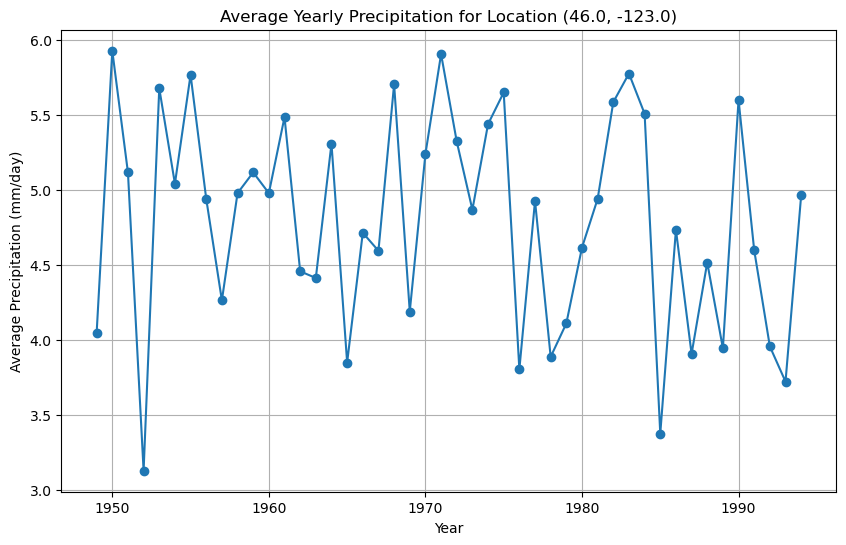

In [290]:
plt.figure(figsize=(10, 6))
plt.plot(average_precipitation_per_year['year'], average_precipitation_per_year['precipitation'], marker='o')
plt.title(f"Average Yearly Precipitation for Location ({central_lat}, {central_lon})")
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.show()

 zoom into the specific geographic zone

In [97]:
# Define the bounds of the area to zoom into
min_lon, max_lon = -117, -0
min_lat, max_lat = 43, 44

df_to_fliter = df_flat
# Filter the data for the specified zone
zone_data = df_to_fliter[(df_to_fliter['lon'] >= min_lon) & (df_to_fliter['lon'] <= max_lon) &
               (df_to_fliter['lat'] >= min_lat) & (df_to_fliter['lat'] <= max_lat)]

In [98]:
annual_precip = zone_data.groupby('year')['precipitation'].mean().reset_index()

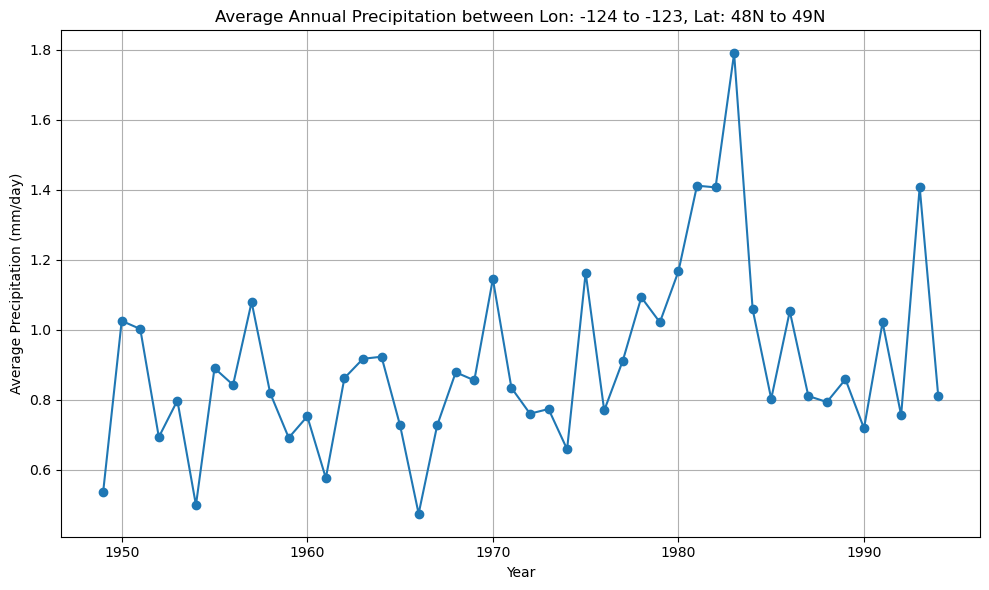

In [99]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(annual_precip['year'], annual_precip['precipitation'], marker='o')
plt.title('Average Annual Precipitation between Lon: -124 to -123, Lat: 48N to 49N')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (mm/day)')
plt.grid(True)
plt.tight_layout()
plt.show()

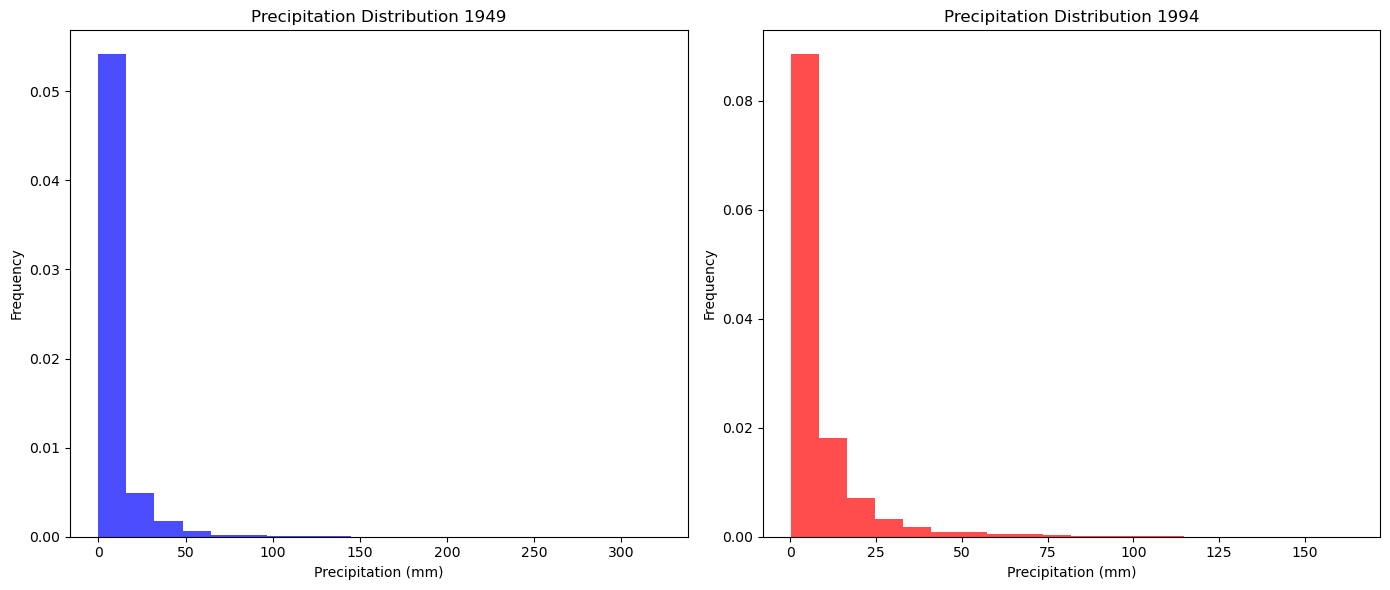

In [100]:
data_year1 = df_non_zero[df_non_zero['year'] == 1949]['precipitation']
data_year2 = df_non_zero[df_non_zero['year'] == 1994]['precipitation']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(data_year1, bins=20, density=True, color='blue', alpha=0.7)
ax[0].set_title('Precipitation Distribution 1949')
ax[0].set_xlabel('Precipitation (mm)')
ax[0].set_ylabel('Frequency')

ax[1].hist(data_year2, bins=20, density=True, color='red', alpha=0.7)
ax[1].set_title('Precipitation Distribution 1994')
ax[1].set_xlabel('Precipitation (mm)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

 Boxplots for Comparing Precipitation Across Different Years or Locations

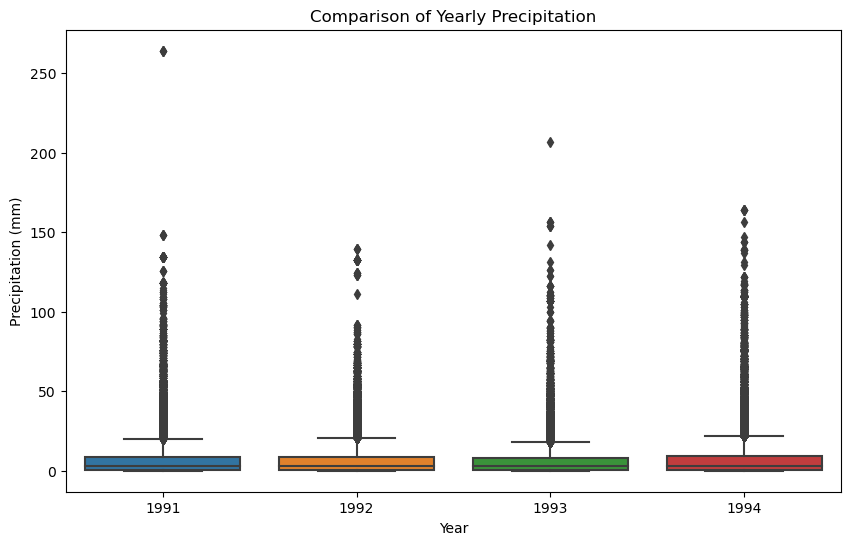

In [101]:
import seaborn as sns

# Prepare data for multiple years or locations
boxplot_data = df_non_zero[df_non_zero['year'].isin([1991, 1992, 1993, 1994])]

plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='precipitation', data=boxplot_data)
plt.title('Comparison of Yearly Precipitation')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.show()

In [340]:
df_flat

time        lat      lon  precipitation  month  year  \
0       1949-01-01  49.760941 -125.625       0.000000      1  1949   
1       1949-01-01  49.760941 -125.000       0.000000      1  1949   
2       1949-01-01  49.760941 -124.375       0.000000      1  1949   
3       1949-01-01  49.760941 -123.750       0.000000      1  1949   
4       1949-01-01  49.760941 -123.125       0.000000      1  1949   
...            ...        ...      ...            ...    ...   ...   
4569867 1994-12-31  42.142059 -118.750      23.900000     12  1994   
4569868 1994-12-31  42.142059 -118.125      25.800001     12  1994   
4569869 1994-12-31  42.142059 -117.500       7.400000     12  1994   
4569870 1994-12-31  42.142059 -116.875       0.000000     12  1994   
4569871 1994-12-31  42.142059 -116.250       0.000000     12  1994   

         day_of_year  week_of_year  day_of_week  location_cluster  
0                  1            53            5                 0  
1                  1            53            5                 0  
2                  1            53            5                 0  
3                  1            53            5                 0  
4                  1            53            5                 0  
...              ...           ...          ...               ...  
4569867          365            52            5                 1  
4569868          365            52            5                 1  
4569869          365            52            5                 1  
4569870          365            52            5                 1  
4569871          365            52            5                 1  

[4569872 rows x 10 columns]

In [297]:
df_time_series = df_flat.copy()

In [298]:
df_time_series['precipitation'] = df_time_series['precipitation'].fillna(0)

In [299]:
df_time_series.set_index(['time', 'lat', 'lon'], inplace=True)

In [300]:
df_time_series

precipitation  month  year  day_of_year  \
time       lat       lon                                                 
1949-01-01 49.760941 -125.625       0.000000      1  1949            1   
                     -125.000       0.000000      1  1949            1   
                     -124.375       0.000000      1  1949            1   
                     -123.750       0.000000      1  1949            1   
                     -123.125       0.000000      1  1949            1   
...                                      ...    ...   ...          ...   
1994-12-31 42.142059 -118.750      23.900000     12  1994          365   
                     -118.125      25.800001     12  1994          365   
                     -117.500       7.400000     12  1994          365   
                     -116.875       0.000000     12  1994          365   
                     -116.250       0.000000     12  1994          365   

                               week_of_year  day_of_week  
time       lat       lon                                  
1949-01-01 49.760941 -125.625            53            5  
                     -125.000            53            5  
                     -124.375            53            5  
                     -123.750            53            5  
                     -123.125            53            5  
...                                     ...          ...  
1994-12-31 42.142059 -118.750            52            5  
                     -118.125            52            5  
                     -117.500            52            5  
                     -116.875            52            5  
                     -116.250            52            5  

[4569872 rows x 6 columns]

In [105]:
from sklearn.cluster import KMeans

In [302]:
selected_data

time        lat      lon  precipitation  month  year  \
116     1949-01-01  46.427681 -123.125       4.600000      1  1949   
117     1949-01-01  46.427681 -122.500      20.200001      1  1949   
132     1949-01-01  45.951500 -123.125      20.600000      1  1949   
133     1949-01-01  45.951500 -122.500      18.200001      1  1949   
388     1949-01-02  46.427681 -123.125       3.300000      1  1949   
...            ...        ...      ...            ...    ...   ...   
4569461 1994-12-30  45.951500 -122.500       0.000000     12  1994   
4569716 1994-12-31  46.427681 -123.125       0.000000     12  1994   
4569717 1994-12-31  46.427681 -122.500       0.000000     12  1994   
4569732 1994-12-31  45.951500 -123.125       0.000000     12  1994   
4569733 1994-12-31  45.951500 -122.500       0.000000     12  1994   

         day_of_year  week_of_year  day_of_week  
116                1            53            5  
117                1            53            5  
132                1            53            5  
133                1            53            5  
388                2            53            6  
...              ...           ...          ...  
4569461          364            52            4  
4569716          365            52            5  
4569717          365            52            5  
4569732          365            52            5  
4569733          365            52            5  

[67204 rows x 9 columns]

In [106]:
central_lat = 47.0
central_lon = -122.0
lat_range = 2.0
lon_range = 2.0

selected_data = filter_data_within_range(df_non_zero, central_lat, central_lon, lat_range, lon_range)

In [107]:
print(f"Data points longitude range: {selected_data['lon'].min()} to {selected_data['lon'].max()}")
print(f"Data points latitude range: {selected_data['lat'].min()} to {selected_data['lat'].max()}")

Data points longitude range: -122.5 to -121.25
Data points latitude range: 46.42768096923828 to 47.85622024536133


In [108]:
import os
# os.environ["OMP_NUM_THREADS"] = "4"
# os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
# os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn

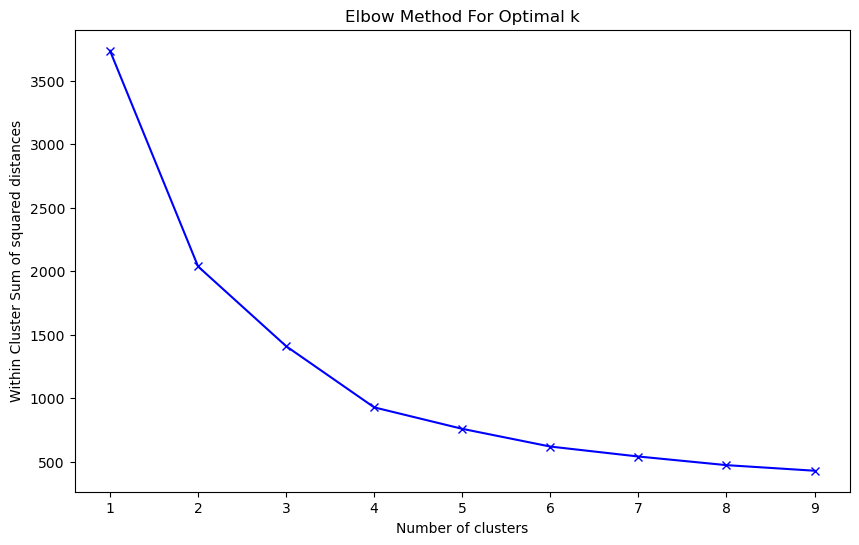

In [394]:
# Calculate the sum of squared distances (SSD) for a range of number of clusters
ssd = []
coords = df_flat[['lat', 'lon']].drop_duplicates().values
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto' ,random_state=42)
    kmeans.fit(coords)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [110]:
coords = df_flat[['lat', 'lon']].drop_duplicates().values
unique_coords_df = pd.DataFrame(coords, columns=['lat', 'lon'])

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)

cluster_labels = kmeans.fit_predict(unique_coords_df)

c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [111]:
unique_coords_df['location_cluster'] = cluster_labels

In [112]:
df_flat = df_flat.merge(unique_coords_df, on=['lat', 'lon'], how='left')

In [113]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import MultiPoint

def plot_precipitation_heatmap_with_clusters(df_clusters, title, extent=None):
    """
    Creates a geospatial plot of the average precipitation data with extended cluster boundaries.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - title: Title for the plot
    - extent: Optional. A tuple of (min_lon, max_lon, min_lat, max_lat) for the map extent.
              If None, the extent is determined automatically.
    """
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Group by 'location_cluster', 'lat', and 'lon', and calculate mean precipitation
    grouped_data = df_clusters.groupby(['location_cluster', 'lat', 'lon'])['precipitation'].mean().reset_index()

    size_factor = 20
    point_sizes = grouped_data['precipitation'] * size_factor

    if not grouped_data.empty:
        sc = ax.scatter(grouped_data['lon'], grouped_data['lat'], c=grouped_data['precipitation'],
                        cmap='cool', s=point_sizes, edgecolor='black', linewidth=1,
                        transform=ccrs.PlateCarree())
        plt.colorbar(sc, label='Average Precipitation (mm/day)')

        # Calculate cluster boundaries
        clusters = []
        for cluster_label, cluster_group in grouped_data.groupby('location_cluster'):
            cluster_lon = cluster_group['lon']
            cluster_lat = cluster_group['lat']
            cluster_points = MultiPoint(list(zip(cluster_lon, cluster_lat)))
            cluster_boundary = cluster_points.convex_hull
            clusters.append((cluster_label, cluster_boundary))

        # Plot cluster boundaries
        for cluster_label, cluster_boundary in clusters:
            if cluster_boundary.geom_type == 'Polygon':
                extended_boundary = cluster_boundary.buffer(0.1)
                coords = np.array(extended_boundary.exterior.coords)
                ax.plot(coords[:, 0], coords[:, 1], label=f'Cluster {cluster_label}', linewidth=2)

        ax.legend()
    else:
        print("No data available to plot.")

    if extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        print("Auto-adjusting extent based on data.")

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(title)
    plt.show()

Auto-adjusting extent based on data.


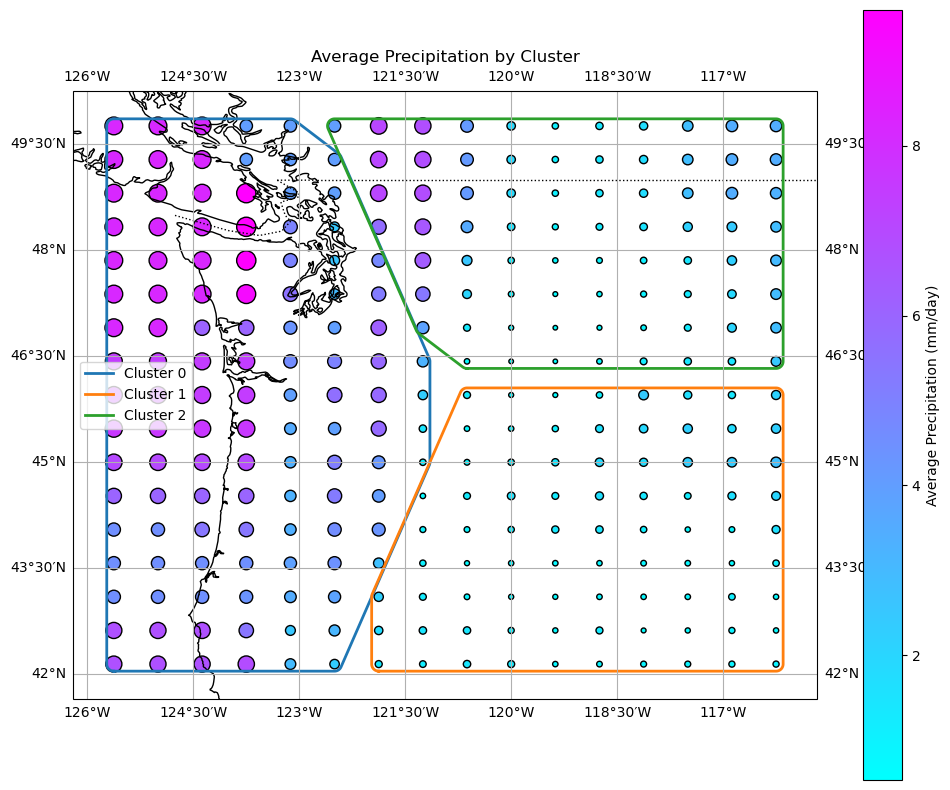

In [114]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster']]

df_clusters = df_clusters.reset_index(drop=True)
plot_precipitation_heatmap_with_clusters(df_clusters, 'Average Precipitation by Cluster')

In [115]:
def plot_precipitation_changes(df_clusters, cluster_label, start_year, end_year):
    """
    Plots the changes in precipitation for a specific cluster over consecutive periods.

    Parameters:
    - df_clusters: pandas DataFrame with time-indexed precipitation data for each location cluster
    - cluster_label: The label of the cluster to plot
    - start_year: The starting year for the first period
    - end_year: The ending year for the last period
    """

    interval = end_year - start_year

    cluster_data = df_clusters[df_clusters['location_cluster'] == cluster_label]

    # Filter data for the specified years
    period_data = cluster_data[(cluster_data['year'] >= start_year) & (cluster_data['year'] <= end_year)]

    # Group by year and calculate mean precipitation
    grouped_data = period_data.groupby('year')['precipitation'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Precipitation (mm/day)')
    plt.title(f'Changes in Precipitation for Cluster {cluster_label} over Consecutive {interval}-Year Periods')
    plt.grid(True)
    plt.xticks(grouped_data.index)
    plt.show()


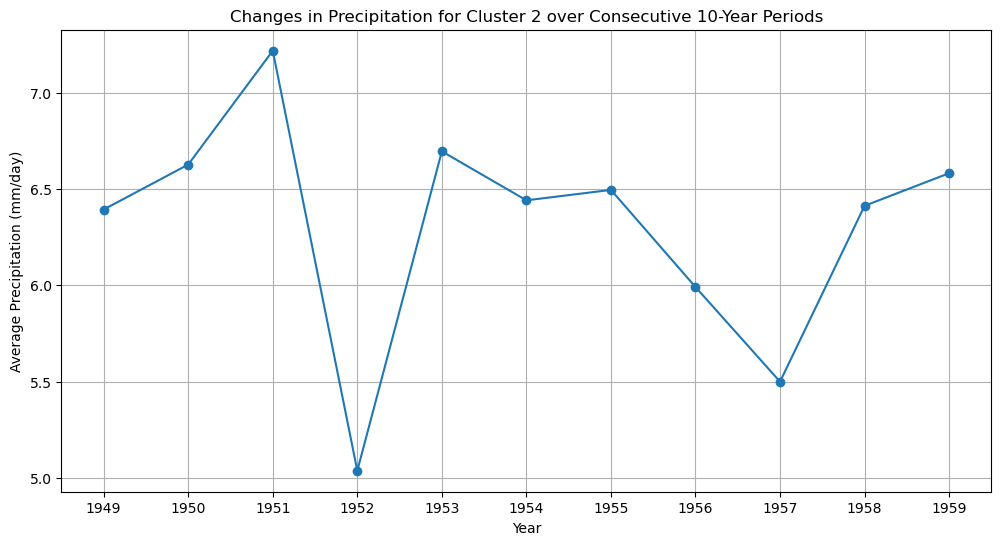

In [116]:
df_clusters = df_flat[['lat','lon','precipitation', 'location_cluster', 'year']]

df_clusters = df_clusters.reset_index(drop=True)

df_clusters_nonzero = df_clusters[df_clusters['precipitation'] > 0]

plot_precipitation_changes(df_clusters_nonzero, 2, 1949, 1959)

In [117]:
df_clusters.set_index('year')

lat      lon  precipitation  location_cluster
year                                                     
1949  49.760941 -125.625      12.451237                 0
1949  49.760941 -125.000      10.839300                 0
1949  49.760941 -124.375       9.390542                 0
1949  49.760941 -123.750       7.837927                 0
1949  49.760941 -123.125       6.168290                 0
...         ...      ...            ...               ...
1994  42.142059 -118.750      23.900000                 1
1994  42.142059 -118.125      25.800001                 1
1994  42.142059 -117.500       7.400000                 1
1994  42.142059 -116.875       0.000000                 1
1994  42.142059 -116.250       0.000000                 1

[4569872 rows x 4 columns]

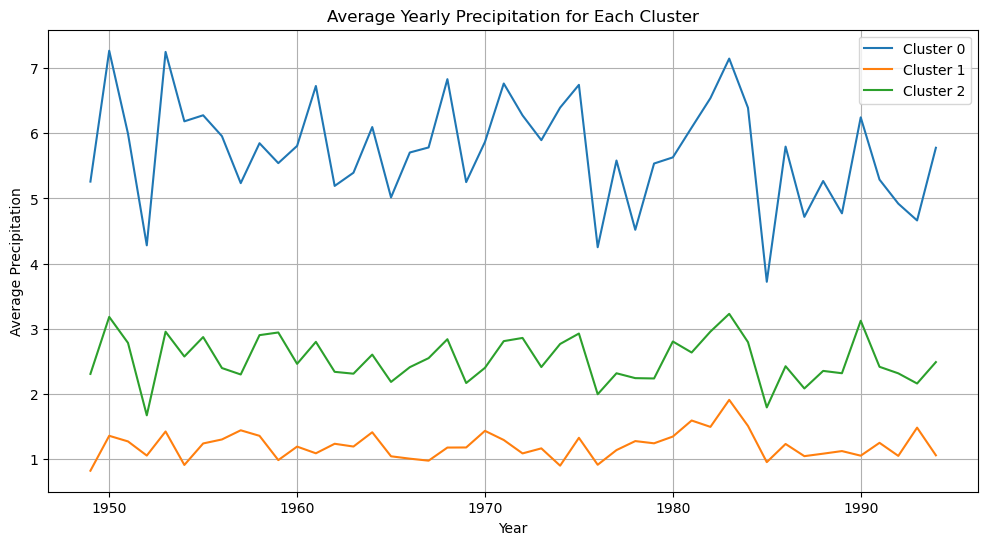

In [118]:
yearly_avg_precipitation = df_clusters.groupby(['location_cluster', 'year'])['precipitation'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
for cluster_label, cluster_data in yearly_avg_precipitation.groupby('location_cluster'):
    plt.plot(cluster_data['year'], cluster_data['precipitation'], label=f'Cluster {cluster_label}')

plt.title('Average Yearly Precipitation for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Average Precipitation')
plt.legend()
plt.grid(True)
plt.show()

In [316]:
yearly_avg_precipitation

location_cluster  year  precipitation
0                   0  1949       2.043605
1                   0  1950       3.090814
2                   0  1951       2.551836
3                   0  1952       1.723564
4                   0  1953       2.995922
..                ...   ...            ...
133                 2  1990       1.732693
134                 2  1991       1.357898
135                 2  1992       1.274605
136                 2  1993       1.200991
137                 2  1994       1.375375

[138 rows x 3 columns]

### Additive Decomposition

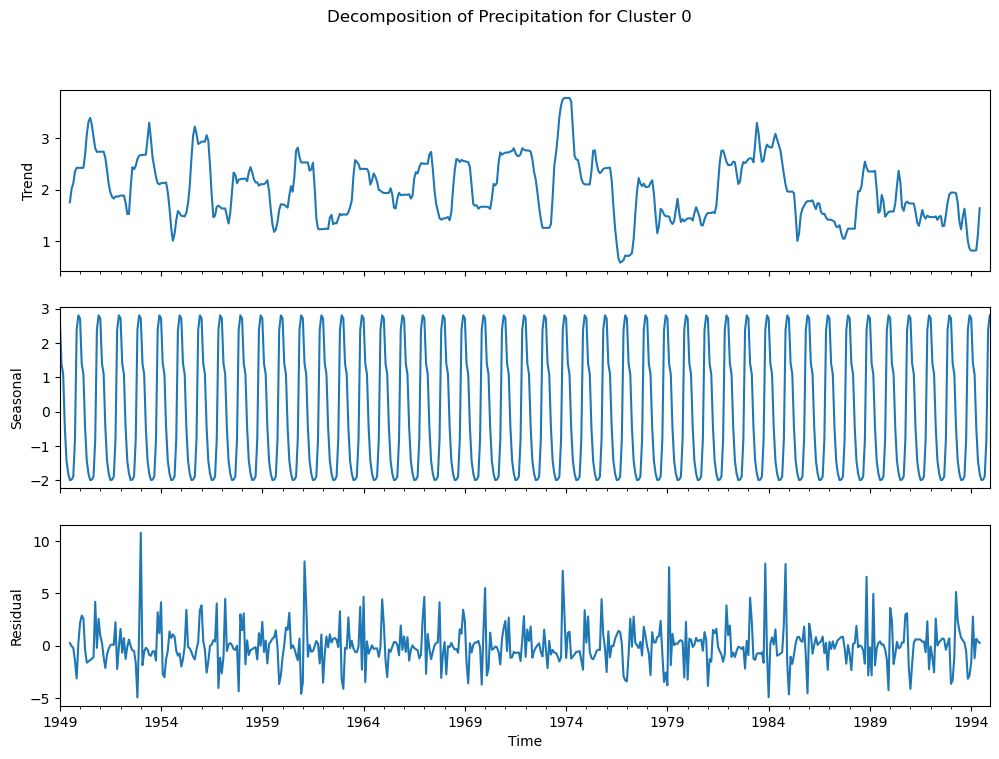

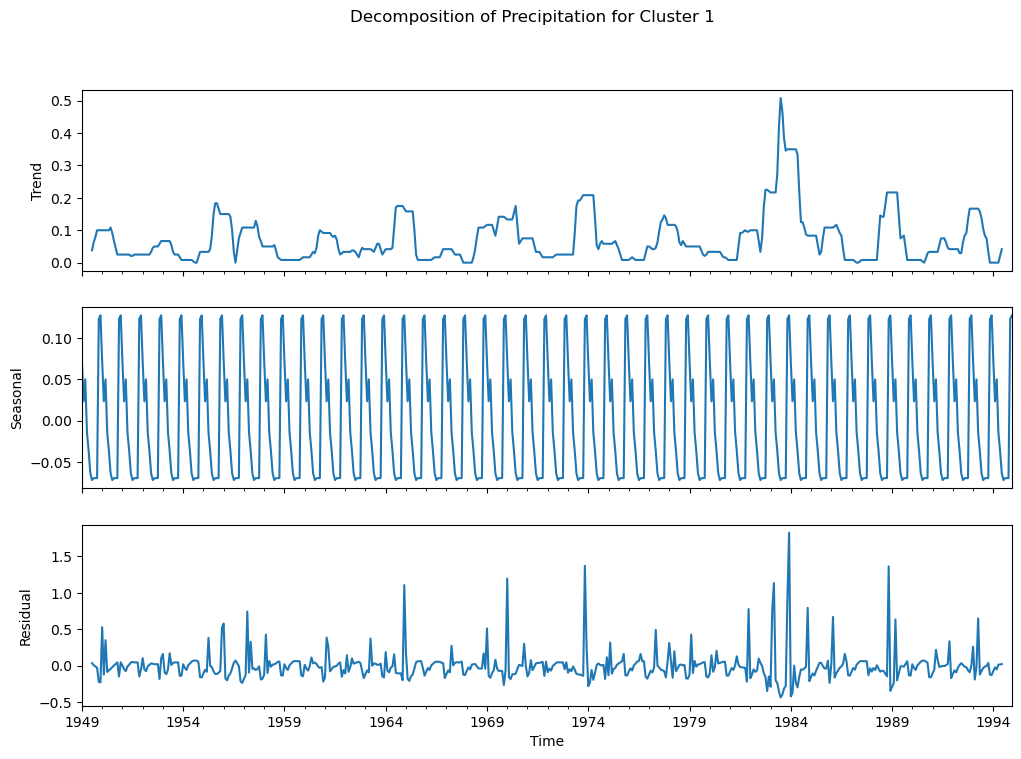

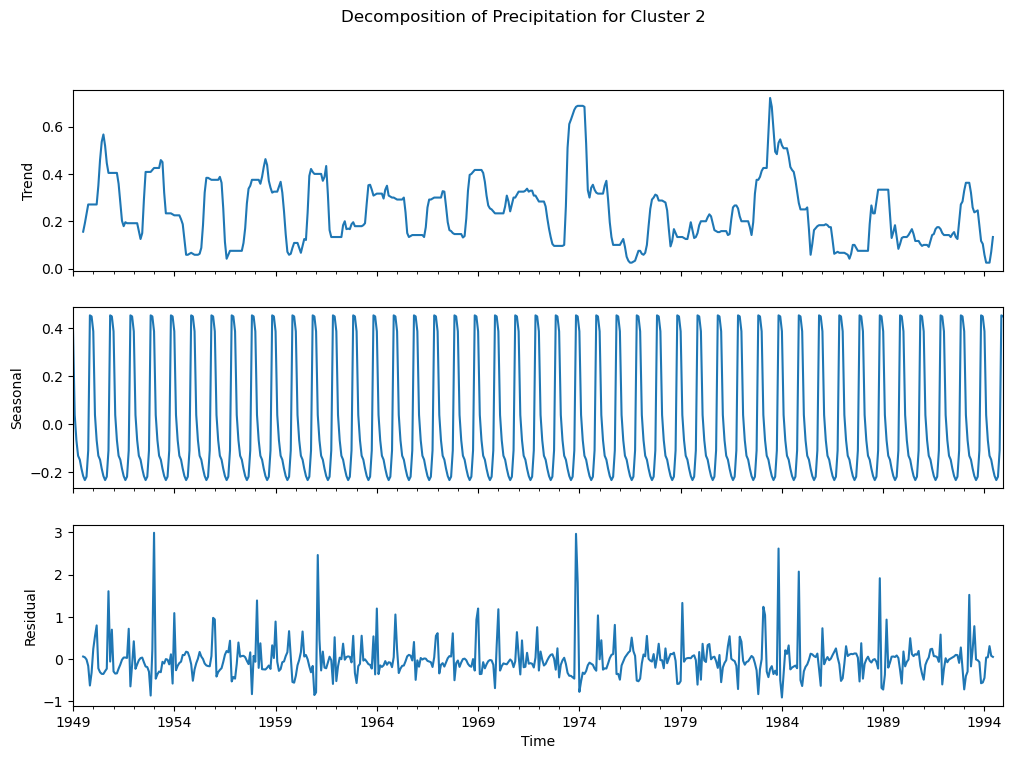

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median ['precipitation'], model='additive')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()


### Multiplicative Decomposition

multiplicative seasonal decomposition cannot handle zero or negative values
- some precipitation can be 0

C:\Users\User\AppData\Local\Temp\ipykernel_23000\2023193888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['precipitation'] += 0.01


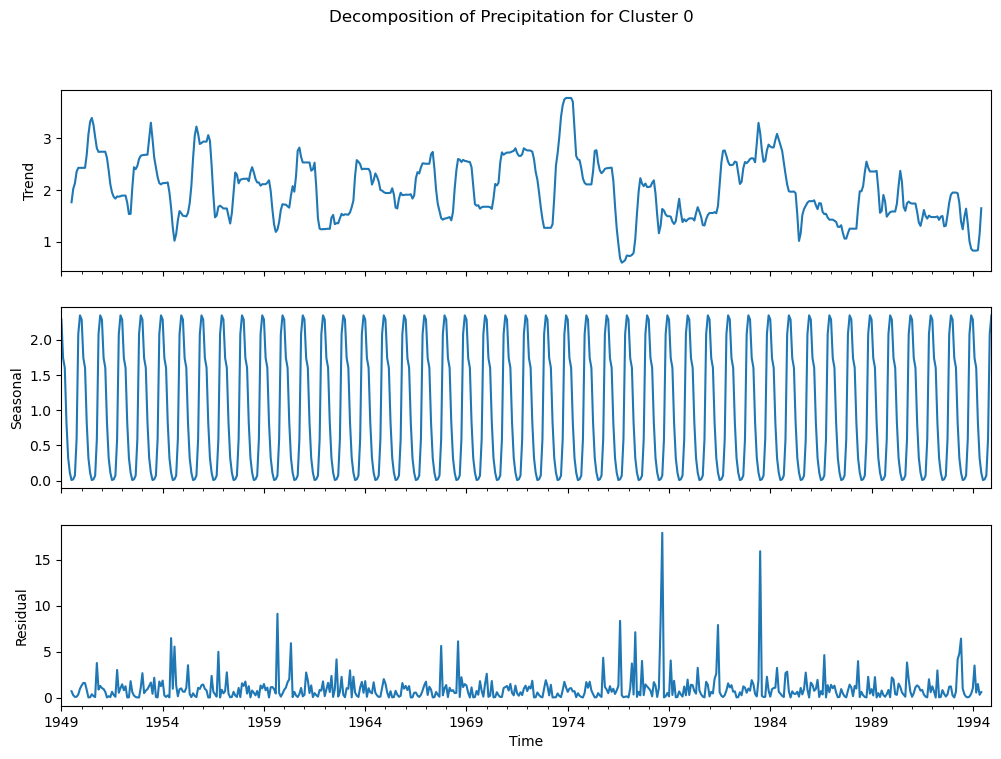

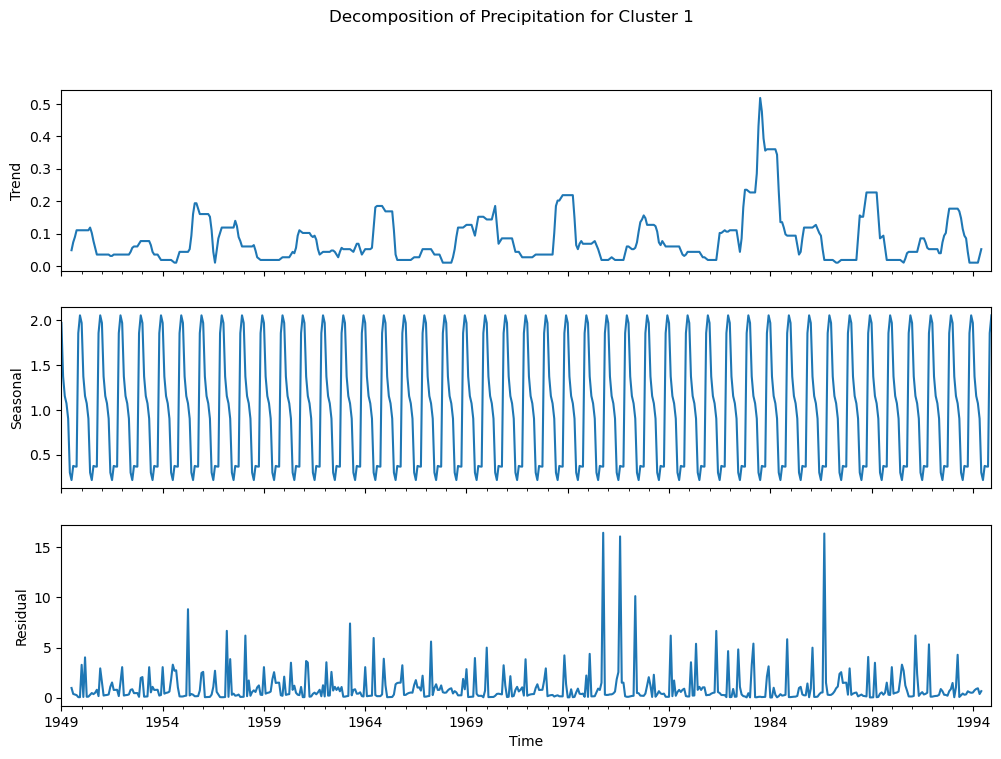

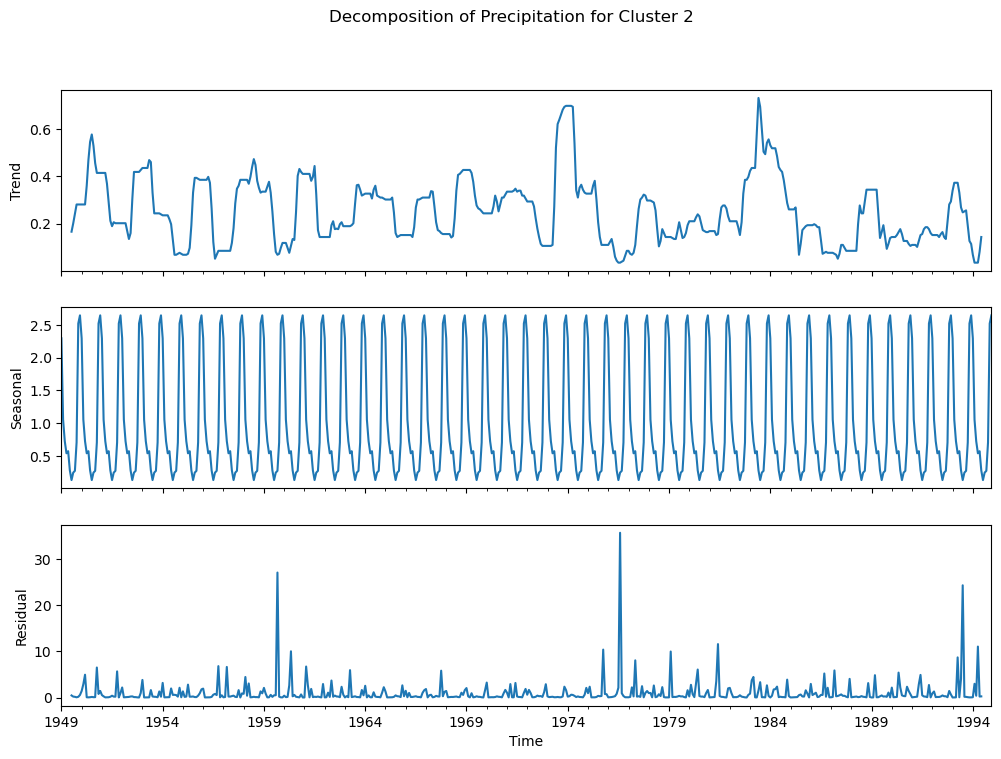

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters['precipitation'] += 0.01

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Resample to ensure there is data for every month
    # cluster_data_resampled = cluster_data.set_index('time').resample('M').mean().fillna(0)

    # cluster_data_resampled_sum = cluster_data.set_index('time').resample('M').sum().fillna(0)

    cluster_data_resampled_median = cluster_data.set_index('time').resample('M').median().fillna(0)
    
    # Decompose the resampled time series
    decomposition = seasonal_decompose(cluster_data_resampled_median['precipitation'], model='multiplicative')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    trend.plot(ax=ax1, legend=False)
    ax1.set_ylabel('Trend')
    seasonal.plot(ax=ax2, legend=False)
    ax2.set_ylabel('Seasonal')
    residual.plot(ax=ax3, legend=False)
    ax3.set_ylabel('Residual')
    
    # Add titles, labels, etc.
    plt.suptitle(f"Decomposition of Precipitation for Cluster {cluster_label}")
    plt.xlabel('Time')
    plt.show()

### Augmented Dickey-Fuller test (Stationary test)

In [130]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(precipitation_df):

    for cluster_label, cluster_data in precipitation_df.groupby('location_cluster'):
        result = adfuller(cluster_data['precipitation'])
        
        print(f"Cluster {cluster_label}:")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print()


In [131]:
# Group by location_cluster and month, calculate the mean precipitation
monthly_avg_precipitation = df_flat.groupby(['location_cluster', df_flat['time'].dt.month])['precipitation'].mean().reset_index()

adfuller_test(monthly_avg_precipitation)

Cluster 0:
ADF Statistic: -2.965459202634706
p-value: 0.038248417424994796
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487

Cluster 1:
ADF Statistic: -3.158995229296673
p-value: 0.022484304647853972
Critical Values:
   1%: -4.9386902332361515
   5%: -3.477582857142857
   10%: -2.8438679591836733

Cluster 2:
ADF Statistic: -1.9876186745969395
p-value: 0.29202812627648356
Critical Values:
   1%: -4.331573
   5%: -3.23295
   10%: -2.7487



### ACF & PACF

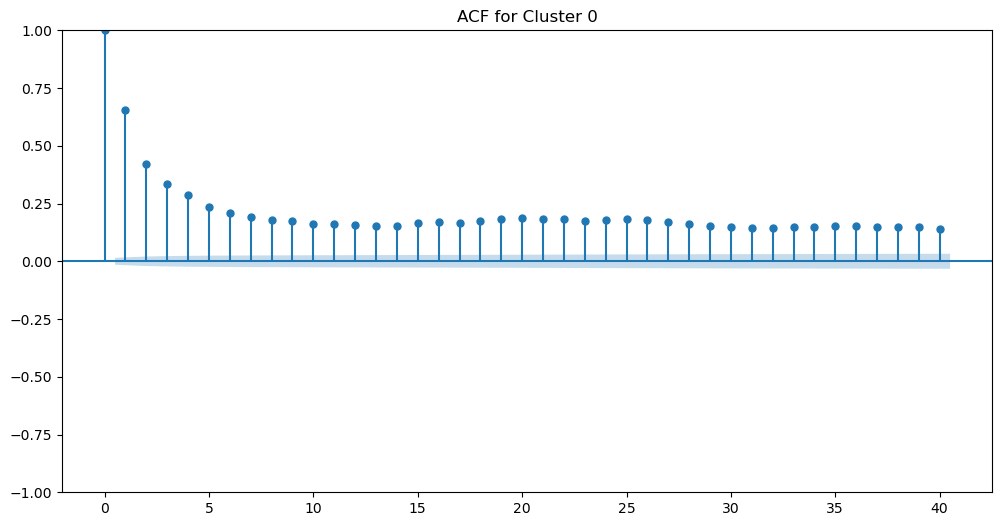

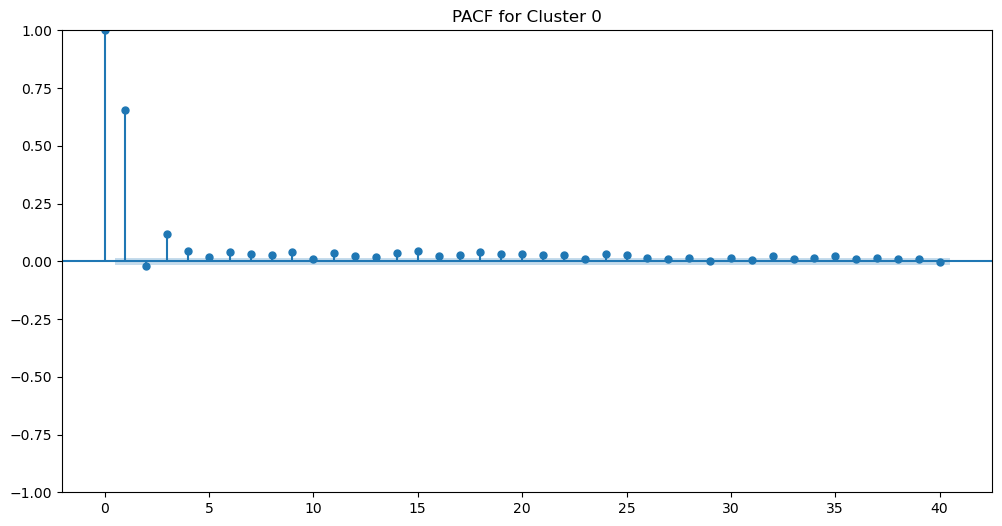

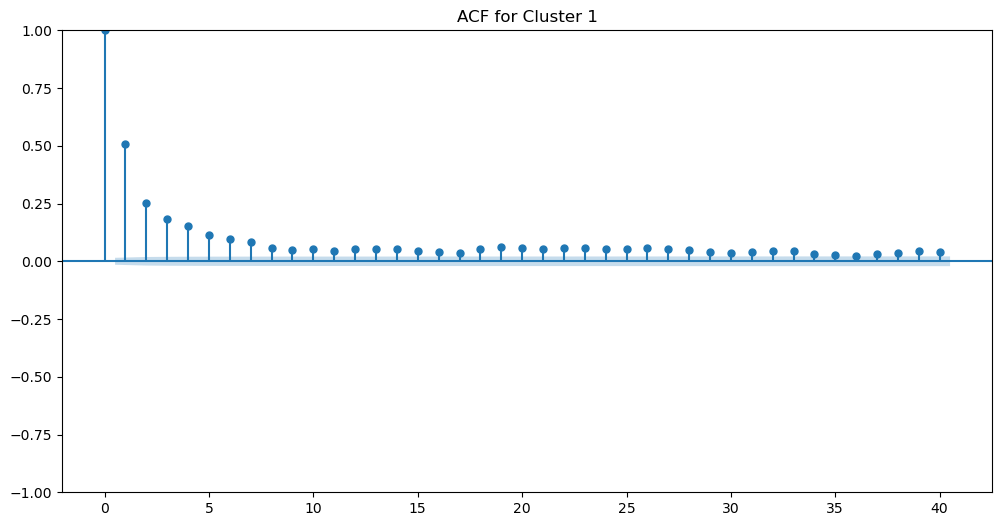

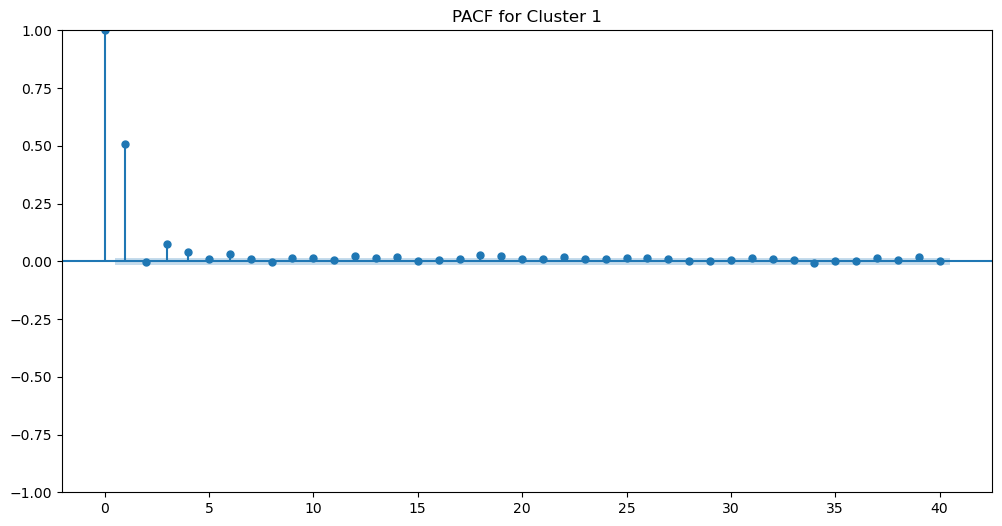

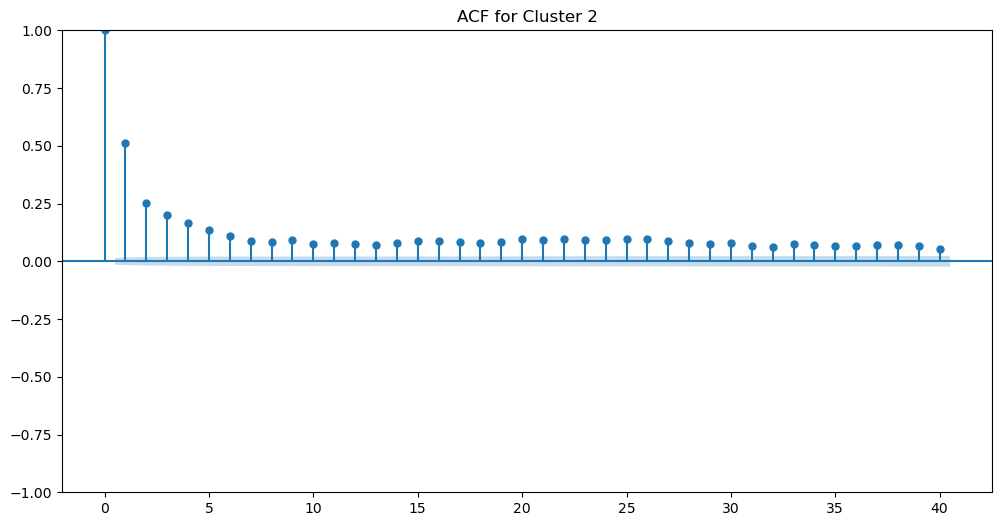

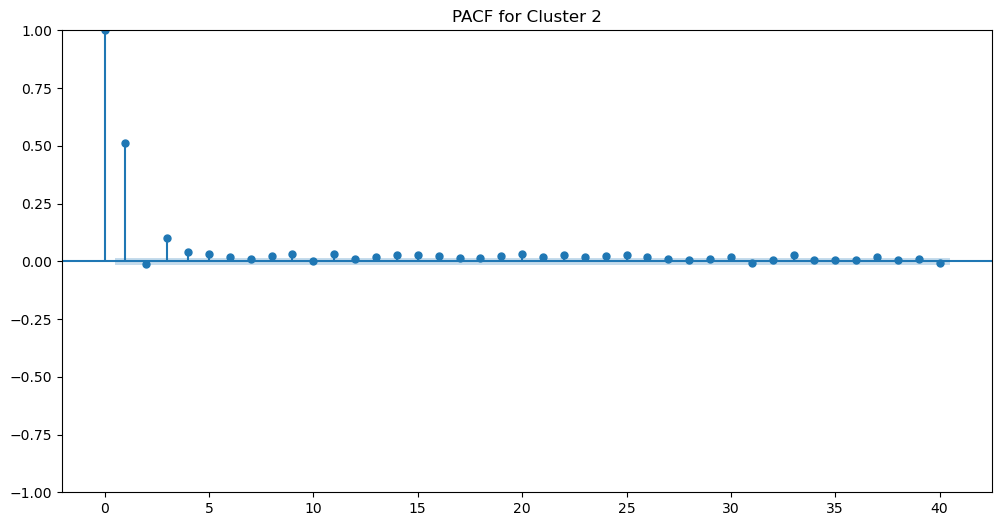

In [132]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_clusters = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'mean'}).reset_index()

for cluster_label, cluster_data in df_clusters.groupby('location_cluster'):
    # Plot ACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(cluster_data['precipitation'], lags=40, ax=ax)
    ax.set_title(f'ACF for Cluster {cluster_label}')
    plt.show()

    # Plot PACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(cluster_data['precipitation'], lags=40, ax=ax)
    ax.set_title(f'PACF for Cluster {cluster_label}')
    plt.show()

Corr heatmap

C:\Users\User\AppData\Local\Temp\ipykernel_23000\1076382932.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_flat.corr()


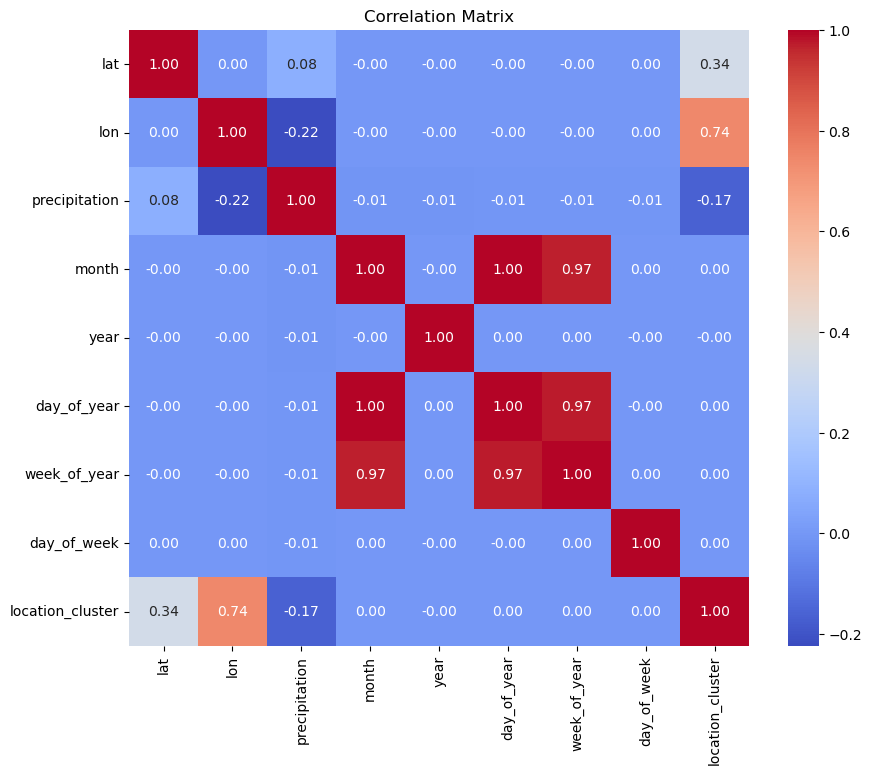

In [395]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_flat.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

## Differencing

In [439]:
def derive_temporal_features(df):
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_week'] = df['time'].dt.dayofweek
    df['day_of_year'] = df['time'].dt.dayofyear
    df['quarter'] = df['time'].dt.quarter

    # Cyclical features
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    return df

In [310]:
df_clusters_diff = df_flat[['precipitation', 'location_cluster', 'time']]

df_clusters_diff = df_clusters.groupby(['time', 'location_cluster']).agg({'precipitation': 'median'}).reset_index()

for cluster_label, cluster_data in df_clusters_diff.groupby('location_cluster'):
    cluster_data.sort_values('time', inplace=True)
    
    # Perform differencing
    cluster_data['precipitation_diff'] = cluster_data['precipitation'].diff(1)
    
    # Merge back into the original DataFrame
    df_clusters_diff.loc[(df_clusters['location_cluster'] == cluster_label) & (df_clusters['time'].isin(cluster_data['time'])), 'precipitation_diff'] = cluster_data['precipitation_diff'].values
    
    # print(f"Differenced data for Cluster {cluster_label}:")
    # print(cluster_data[['time', 'precipitation_diff']])

In [311]:
df_clusters_diff = derive_temporal_features(df_clusters_diff)

In [312]:
df_clusters_diff = df_clusters_diff.iloc[3:]

In [313]:
df_clusters_diff

time  location_cluster  precipitation  precipitation_diff  year  \
3     1949-01-02                 0       4.724285          -13.319745  1949   
4     1949-01-02                 1       0.716485           -2.745112  1949   
5     1949-01-02                 2       1.410902           -3.211200  1949   
6     1949-01-03                 0       0.342431           -4.381854  1949   
7     1949-01-03                 1       0.017806           -0.698678  1949   
...          ...               ...            ...                 ...   ...   
50398 1994-12-30                 1       0.000000           -0.019753  1994   
50399 1994-12-30                 2       0.000000           -0.284211  1994   
50400 1994-12-31                 0       0.051304           -1.665217  1994   
50401 1994-12-31                 1       1.743210            1.743210  1994   
50402 1994-12-31                 2       0.019737            0.019737  1994   

       month  day  week_of_year  day_of_week  quarter  month_cos  \
3          1    2            53            6        1   0.866025   
4          1    2            53            6        1   0.866025   
5          1    2            53            6        1   0.866025   
6          1    3             1            0        1   0.866025   
7          1    3             1            0        1   0.866025   
...      ...  ...           ...          ...      ...        ...   
50398     12   30            52            4        4   1.000000   
50399     12   30            52            4        4   1.000000   
50400     12   31            52            5        4   1.000000   
50401     12   31            52            5        4   1.000000   
50402     12   31            52            5        4   1.000000   

       day_of_week_cos  
3             0.623490  
4             0.623490  
5             0.623490  
6             1.000000  
7             1.000000  
...                ...  
50398        -0.900969  
50399        -0.900969  
50400        -0.222521  
50401        -0.222521  
50402        -0.222521  

[50400 rows x 12 columns]

In [314]:
adfuller_test(df_clusters_diff)

Cluster 0:
ADF Statistic: -11.2197556053246
p-value: 2.0272996225563127e-20
Critical Values:
   1%: -3.4307402560948677
   5%: -2.861712477640846
   10%: -2.5668618054544683

Cluster 1:
ADF Statistic: -19.192146558340447
p-value: 0.0
Critical Values:
   1%: -3.430739930308078
   5%: -2.8617123336655235
   10%: -2.5668617288184303

Cluster 2:
ADF Statistic: -15.060121279310183
p-value: 9.029927274737318e-28
Critical Values:
   1%: -3.4307400698643598
   5%: -2.86171239533979
   10%: -2.566861761646774



ACF & PACF after differencing

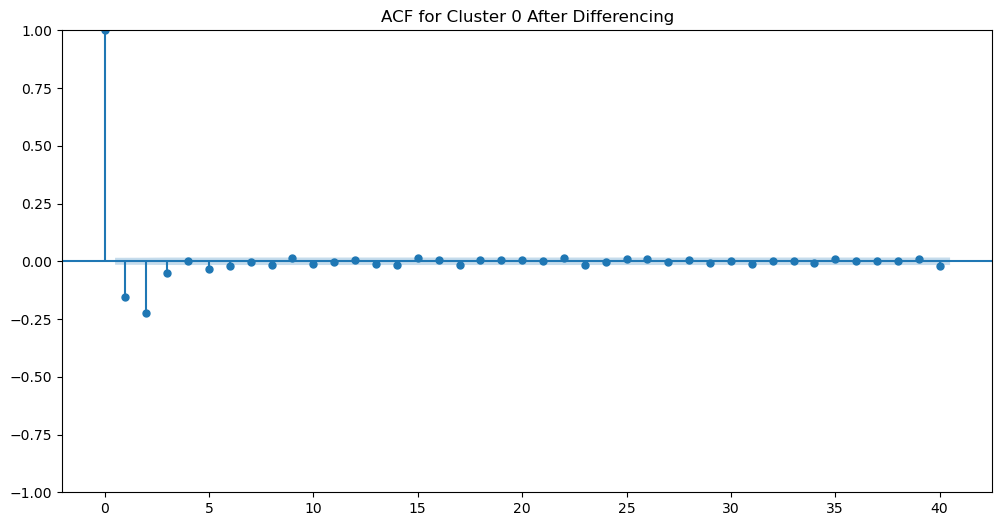

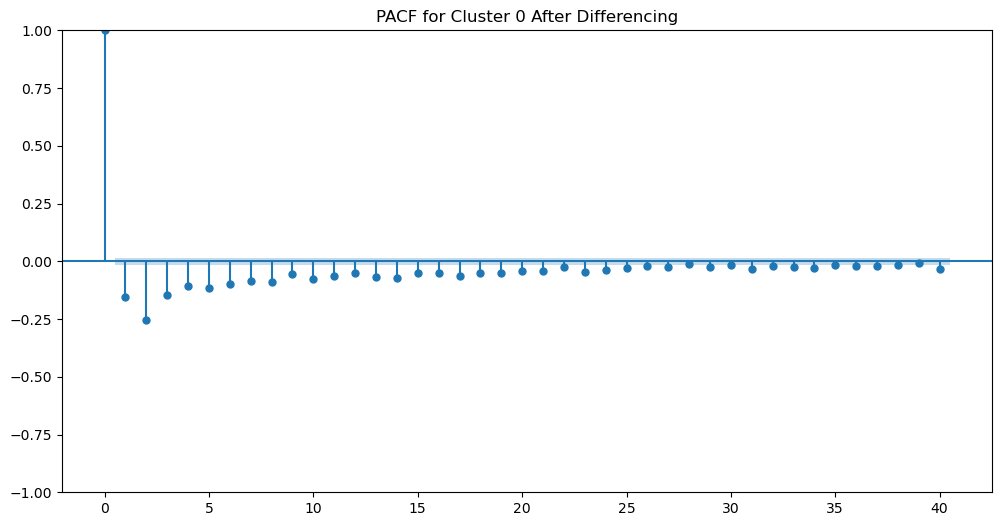

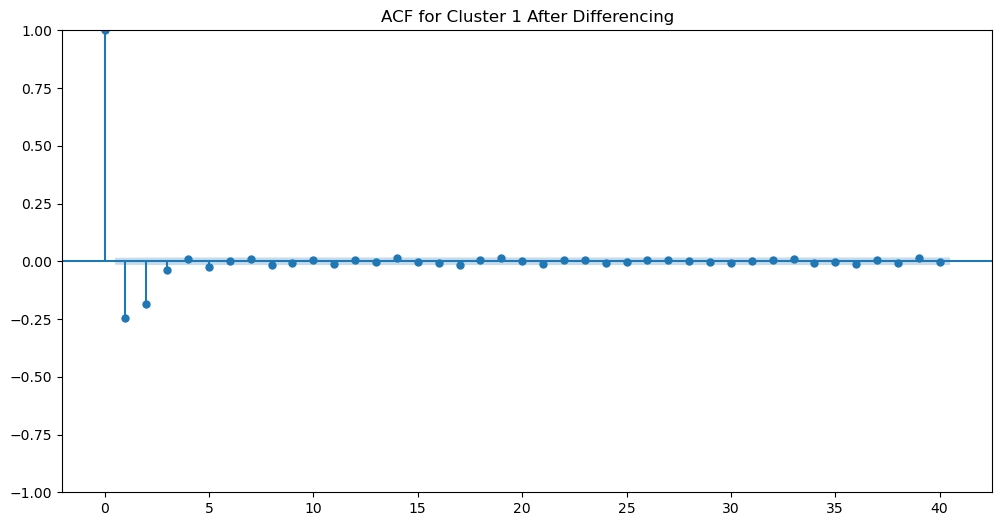

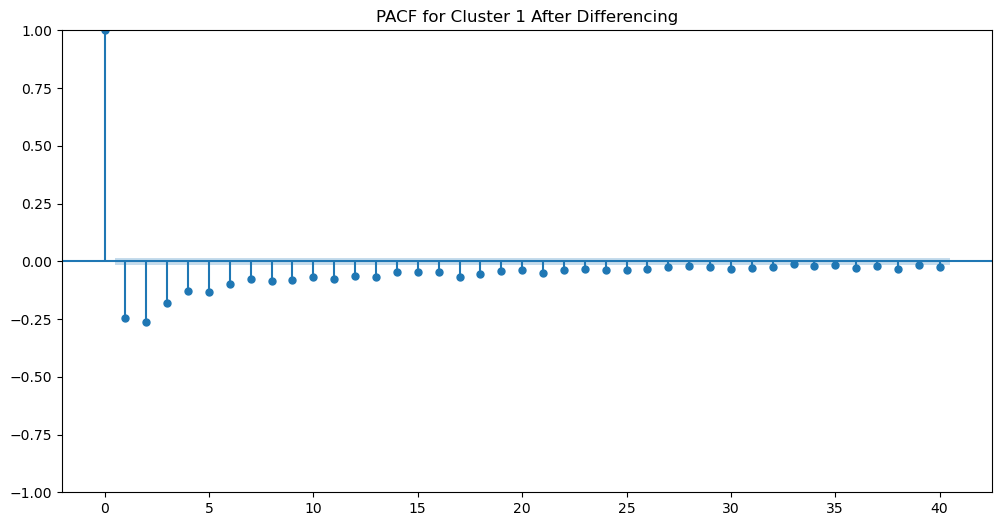

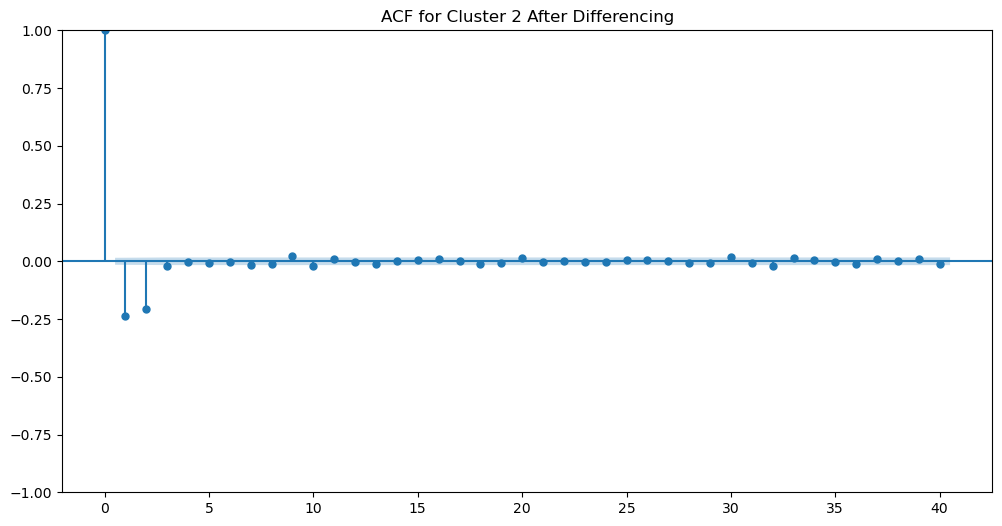

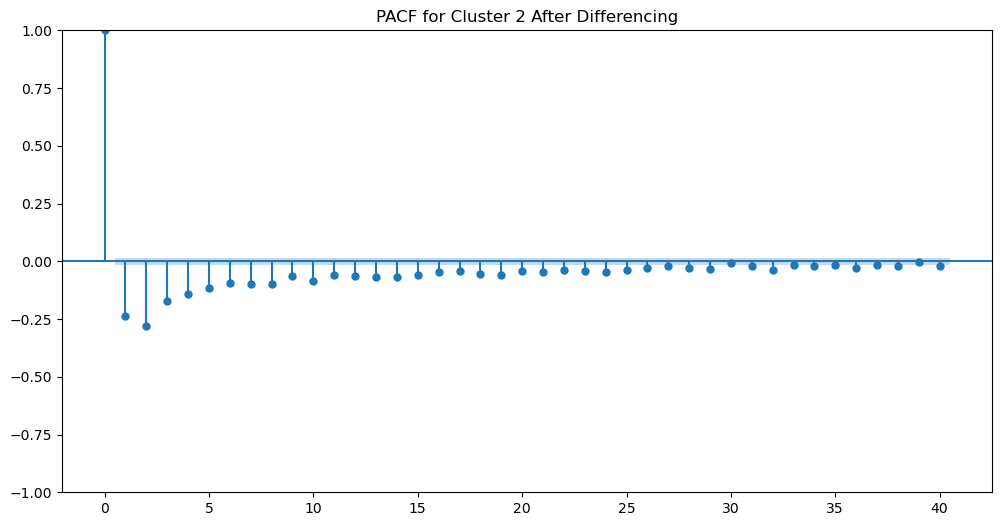

In [315]:
for cluster_label, cluster_data in df_clusters_diff.groupby('location_cluster'):
    # Plot ACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(cluster_data['precipitation_diff'], lags=40, ax=ax)
    ax.set_title(f'ACF for Cluster {cluster_label} After Differencing')
    plt.show()

    # Plot PACF
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(cluster_data['precipitation_diff'], lags=40, ax=ax)
    ax.set_title(f'PACF for Cluster {cluster_label} After Differencing')
    plt.show()

# Training Models

Only specific location

In [316]:
df_flat['lat'].unique()

array([49.76094, 49.28476, 48.80858, 48.3324 , 47.85622, 47.38004,
       46.90386, 46.42768, 45.9515 , 45.47532, 44.99914, 44.52296,
       44.04678, 43.5706 , 43.09442, 42.61824, 42.14206], dtype=float32)

In [223]:
df_flat['lon'].unique()

array([-125.625, -125.   , -124.375, -123.75 , -123.125, -122.5  ,
       -121.875, -121.25 , -120.625, -120.   , -119.375, -118.75 ,
       -118.125, -117.5  , -116.875, -116.25 ], dtype=float32)

In [317]:
df_clusters_diff

time  location_cluster  precipitation  precipitation_diff  year  \
3     1949-01-02                 0       4.724285          -13.319745  1949   
4     1949-01-02                 1       0.716485           -2.745112  1949   
5     1949-01-02                 2       1.410902           -3.211200  1949   
6     1949-01-03                 0       0.342431           -4.381854  1949   
7     1949-01-03                 1       0.017806           -0.698678  1949   
...          ...               ...            ...                 ...   ...   
50398 1994-12-30                 1       0.000000           -0.019753  1994   
50399 1994-12-30                 2       0.000000           -0.284211  1994   
50400 1994-12-31                 0       0.051304           -1.665217  1994   
50401 1994-12-31                 1       1.743210            1.743210  1994   
50402 1994-12-31                 2       0.019737            0.019737  1994   

       month  day  week_of_year  day_of_week  quarter  month_cos  \
3          1    2            53            6        1   0.866025   
4          1    2            53            6        1   0.866025   
5          1    2            53            6        1   0.866025   
6          1    3             1            0        1   0.866025   
7          1    3             1            0        1   0.866025   
...      ...  ...           ...          ...      ...        ...   
50398     12   30            52            4        4   1.000000   
50399     12   30            52            4        4   1.000000   
50400     12   31            52            5        4   1.000000   
50401     12   31            52            5        4   1.000000   
50402     12   31            52            5        4   1.000000   

       day_of_week_cos  
3             0.623490  
4             0.623490  
5             0.623490  
6             1.000000  
7             1.000000  
...                ...  
50398        -0.900969  
50399        -0.900969  
50400        -0.222521  
50401        -0.222521  
50402        -0.222521  

[50400 rows x 12 columns]

In [176]:
# specific_location_df = filter_data_with_zero(df_flat, min_lon=-119, max_lon=-118.5, min_lat=42.0, max_lat=42.5)

In [177]:
# specific_location_df = specific_location_df.set_index('time')
# specific_location_df.index.freq = "D"

In [190]:
# weekly_precipitation = specific_location_df['precipitation'].resample('w').median()

# # Reset the index to have 'time' as a column again
# weekly_precipitation = weekly_precipitation.reset_index()

# weekly_precipitation.set_index('time')

# weekly_precipitation.index.freq = "W"

In [188]:
# weekly_precipitation

time  precipitation
0    1949-01-02       0.781189
1    1949-01-09       0.009265
2    1949-01-16       0.000000
3    1949-01-23       0.532412
4    1949-01-30       0.045342
...         ...            ...
2396 1994-12-04       0.200000
2397 1994-12-11       0.000000
2398 1994-12-18       0.000000
2399 1994-12-25       0.000000
2400 1995-01-01       0.000000

[2401 rows x 2 columns]

In [179]:
# # Calculate the total number of rows
# total_rows = len(specific_location_df)

# # Calculate the number of non-zero precipitation values
# non_zero_precipitation_count = specific_location_df[specific_location_df['precipitation'] != 0]['precipitation'].count()

# # Calculate the percentage of non-zero precipitation values
# non_zero_percentage = (non_zero_precipitation_count / total_rows) * 100

# print(f"Percentage of non-zero precipitation values: {non_zero_percentage:.2f}%")

Percentage of non-zero precipitation values: 27.09%


In [191]:
# non_zero_precipitation_count = weekly_precipitation[weekly_precipitation['precipitation'] == 0]['precipitation'].count()

# non_zero_precipitation_count

1928

Use diff data

In [212]:
df_clusters_diff

time  location_cluster  precipitation  precipitation_diff
3     1949-01-02                 0       4.724285          -13.319745
4     1949-01-02                 1       0.716485           -2.745112
5     1949-01-02                 2       1.410902           -3.211200
6     1949-01-03                 0       0.342431           -4.381854
7     1949-01-03                 1       0.017806           -0.698678
...          ...               ...            ...                 ...
50398 1994-12-30                 1       0.000000           -0.019753
50399 1994-12-30                 2       0.000000           -0.284211
50400 1994-12-31                 0       0.051304           -1.665217
50401 1994-12-31                 1       1.743210            1.743210
50402 1994-12-31                 2       0.019737            0.019737

[50400 rows x 4 columns]

In [318]:
df_clusters_diff

time  location_cluster  precipitation  precipitation_diff  year  \
3     1949-01-02                 0       4.724285          -13.319745  1949   
4     1949-01-02                 1       0.716485           -2.745112  1949   
5     1949-01-02                 2       1.410902           -3.211200  1949   
6     1949-01-03                 0       0.342431           -4.381854  1949   
7     1949-01-03                 1       0.017806           -0.698678  1949   
...          ...               ...            ...                 ...   ...   
50398 1994-12-30                 1       0.000000           -0.019753  1994   
50399 1994-12-30                 2       0.000000           -0.284211  1994   
50400 1994-12-31                 0       0.051304           -1.665217  1994   
50401 1994-12-31                 1       1.743210            1.743210  1994   
50402 1994-12-31                 2       0.019737            0.019737  1994   

       month  day  week_of_year  day_of_week  quarter  month_cos  \
3          1    2            53            6        1   0.866025   
4          1    2            53            6        1   0.866025   
5          1    2            53            6        1   0.866025   
6          1    3             1            0        1   0.866025   
7          1    3             1            0        1   0.866025   
...      ...  ...           ...          ...      ...        ...   
50398     12   30            52            4        4   1.000000   
50399     12   30            52            4        4   1.000000   
50400     12   31            52            5        4   1.000000   
50401     12   31            52            5        4   1.000000   
50402     12   31            52            5        4   1.000000   

       day_of_week_cos  
3             0.623490  
4             0.623490  
5             0.623490  
6             1.000000  
7             1.000000  
...                ...  
50398        -0.900969  
50399        -0.900969  
50400        -0.222521  
50401        -0.222521  
50402        -0.222521  

[50400 rows x 12 columns]

### Resample data into 3 month interval

In [755]:
def extract_process_cluster_data(df_clusters, cluster: int):
    # Check if 'precipitation_diff' is in the df
    key = 'precipitation_diff' if 'precipitation_diff' in df_clusters.columns else 'precipitation'

    # Extract specific cluster
    cluster_data_clipped = df_clusters[df_clusters['location_cluster'] == cluster].copy()

    # Clip negative values in precipitation_diff to 0
    cluster_data_clipped[key] = cluster_data_clipped[key].clip(lower=0)

    # Drop precipitation and location_cluster columns
    # cluster_data_clipped.drop(['precipitation', 'location_cluster'], axis=1, inplace=True)

    # Ensure the 'time' column is a datetime-like object
    cluster_data_clipped['time'] = pd.to_datetime(cluster_data_clipped['time'])

    # Set the 'time' column as the index
    cluster_data_clipped.set_index('time', inplace=True)

    return cluster_data_clipped

In [756]:
def process_all_clusters(df_clusters, resample_interval ='3M'):
    # List to store processed cluster data
    processed_clusters = []

    # Iterate over each cluster
    for cluster_id in df_clusters['location_cluster'].unique():
        # Extract and process data for the current cluster
        cluster_data_clipped = extract_process_cluster_data(df_clusters, cluster_id)

        # Check if 'precipitation_diff' is in the df
        key = 'precipitation_diff' if 'precipitation_diff' in df_clusters.columns else 'precipitation'

        # Resample to month intervals to represent seasons
        seasonal_precipitation = cluster_data_clipped[key].resample(resample_interval).mean()

        # Reset index to have 'time' as a column
        seasonal_precipitation = seasonal_precipitation.reset_index()

        # Set 'time' as index
        seasonal_precipitation.set_index('time', inplace=True)

        # Add cluster_id column for identification
        seasonal_precipitation['location_cluster'] = cluster_id

        # Append processed cluster data to the list
        processed_clusters.append(seasonal_precipitation)

    # Concatenate processed cluster data into a single DataFrame
    processed_df = pd.concat(processed_clusters)

    return processed_df

Extract one cluster data

In [361]:
cluster_data_clipped = extract_process_cluster_data(df_clusters_diff, 0)

cluster_data_clipped

precipitation_diff  year  month  day  week_of_year  day_of_week  \
time                                                                          
1949-01-02            0.000000  1949      1    2            53            6   
1949-01-03            0.000000  1949      1    3             1            0   
1949-01-04            0.000000  1949      1    4             1            1   
1949-01-05            0.229306  1949      1    5             1            2   
1949-01-06            4.585833  1949      1    6             1            3   
...                        ...   ...    ...  ...           ...          ...   
1994-12-27           14.697391  1994     12   27            52            1   
1994-12-28            0.000000  1994     12   28            52            2   
1994-12-29            0.000000  1994     12   29            52            3   
1994-12-30            0.989565  1994     12   30            52            4   
1994-12-31            0.000000  1994     12   31            52            5   

            quarter  month_cos  day_of_week_cos  
time                                             
1949-01-02        1   0.866025         0.623490  
1949-01-03        1   0.866025         1.000000  
1949-01-04        1   0.866025         0.623490  
1949-01-05        1   0.866025        -0.222521  
1949-01-06        1   0.866025        -0.900969  
...             ...        ...              ...  
1994-12-27        4   1.000000         0.623490  
1994-12-28        4   1.000000        -0.222521  
1994-12-29        4   1.000000        -0.900969  
1994-12-30        4   1.000000        -0.900969  
1994-12-31        4   1.000000        -0.222521  

[16800 rows x 9 columns]

In [407]:
# Resample to month intervals to represent seasons
seasonal_precipitation = cluster_data_clipped['precipitation_diff'].resample('3M').mean()

# Reset index to have 'time' as a column
seasonal_precipitation = seasonal_precipitation.reset_index()

# Set 'time' as index
seasonal_precipitation.set_index('time', inplace=True)

In [408]:
seasonal_precipitation

precipitation_diff
time                          
1949-01-31            1.068865
1949-04-30            3.060717
1949-07-31            0.882533
1949-10-31            1.334735
1950-01-31            4.088989
...                        ...
1994-01-31            2.179991
1994-04-30            1.989585
1994-07-31            0.970983
1994-10-31            1.658270
1995-01-31            4.462395

[185 rows x 1 columns]

### Train on one cluster

ARIMA

In [570]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [571]:
precipitation_data = seasonal_precipitation

In [572]:
# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(precipitation_data) * 0.8)
train, test = precipitation_data[:train_size], precipitation_data[train_size:]

In [573]:
# Fit ARIMA model
order = (0, 0, 0)  # ARIMA(p, d, q) order
model = ARIMA(train['precipitation_diff'], order=order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
rmse, mae, r2 = evaluate_model(test['precipitation_diff'], forecast)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 1.0256802003664234
RMSE: 1.0127587078699563
MAE: 0.8628539133389314
R-squared: -0.04499310261829992


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)


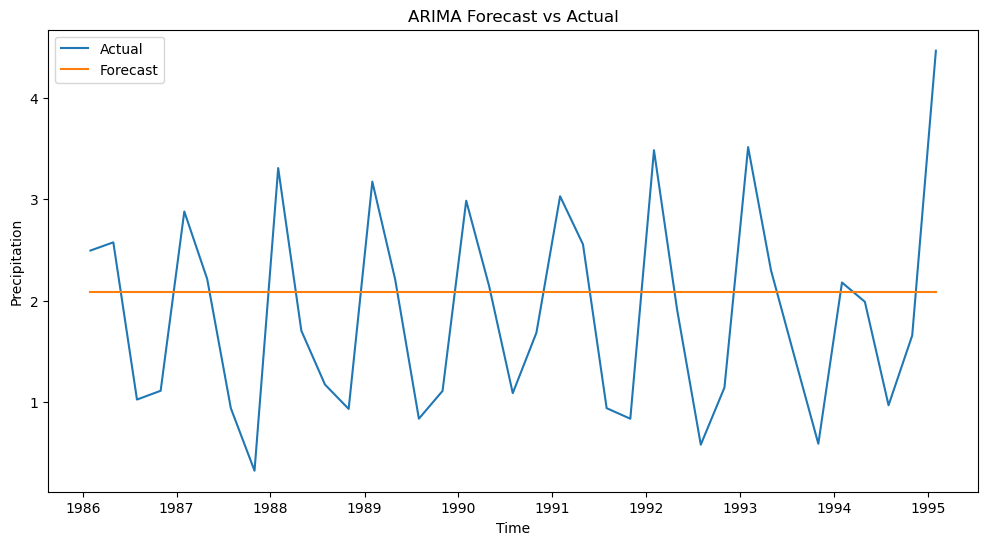

In [413]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['precipitation_diff'], label='Actual')

# Plot the forecasted values
plt.plot(test.index, forecast, label='Forecast')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

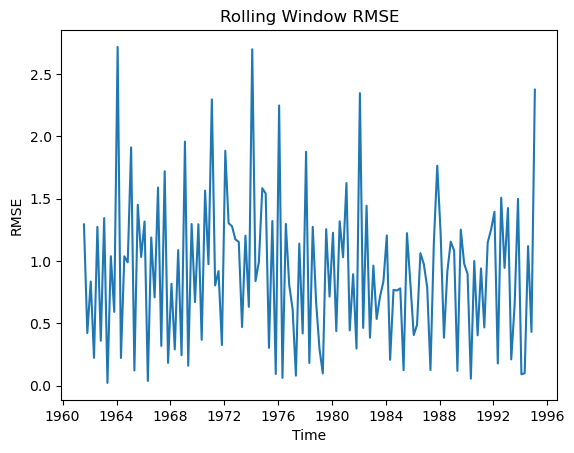

In [414]:
window_size = 50  # Define the window size

# Iterate with a rolling window
rmse_values = []
for i in range(len(precipitation_data) - window_size):
    # Define the training and test sets for the current window
    window_train = precipitation_data['precipitation_diff'].iloc[i:i+window_size]
    window_test = precipitation_data['precipitation_diff'].iloc[i+window_size:i+window_size+1]
    
    # Fit ARIMA model
    model = ARIMA(window_train.values.tolist(), order=(0, 0, 0))

    # Forecast for the next time step
    forecast = model_fit.forecast(steps=1)

    # Calculate RMSE for this step
    rmse = np.sqrt(mean_squared_error(window_test, forecast))
    rmse_values.append(rmse)

# Plot RMSE over time
plt.plot(precipitation_data.index[window_size:], rmse_values)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title('Rolling Window RMSE')
plt.show()

SARIMA

In [415]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model parameters
order = (1, 1, 1)  # ARIMA(p, d, q) order
seasonal_order = (1, 1, 1, 4)  # SARIMA(P, D, Q, S) order

# Fit the SARIMA model
model = SARIMAX(train['precipitation_diff'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
rmse, mae, r2 = evaluate_model(test['precipitation_diff'], forecast)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)


RMSE: 0.4918214146211017
MAE: 0.3826826255170576
R-squared: 0.7535570940452647


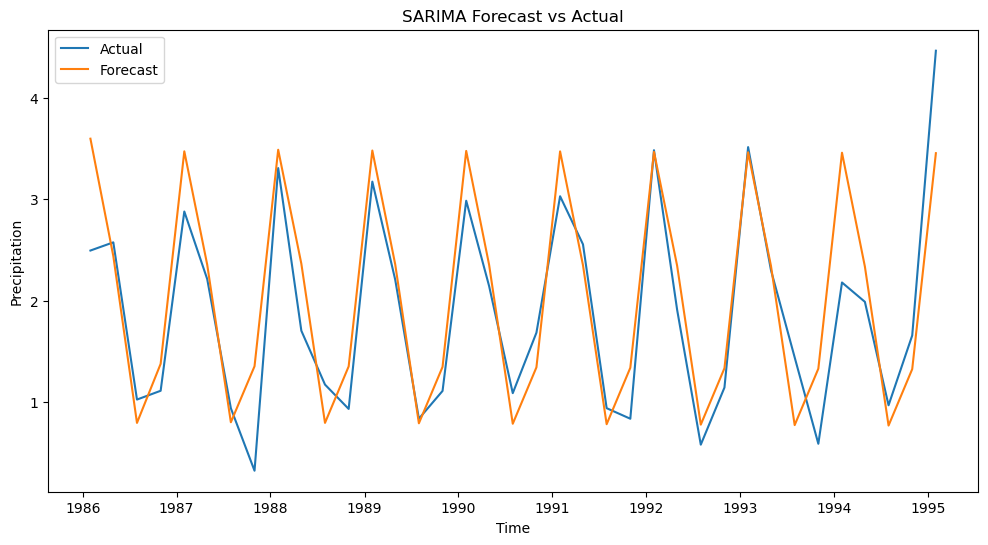

In [416]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['precipitation_diff'], label='Actual')

# Plot the forecasted values
plt.plot(test.index, forecast, label='Forecast')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

HOLT WINTERS

In [417]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters parameters
# set 'mul' for multiplicative trend and seasonality
trend = 'add'  
seasonal = 'add'
seasonal_periods = 12  # Number of periods in a season

# Fit the Holt-Winters model
model = ExponentialSmoothing(train['precipitation_diff'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(len(test))

# Evaluate the model
rmse, mae, r2 = evaluate_model(test['precipitation_diff'], forecast)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 0.48346211109863774
MAE: 0.38454083967861996
R-squared: 0.7618632950153356


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-OCT will be used.
  self._init_dates(dates, freq)


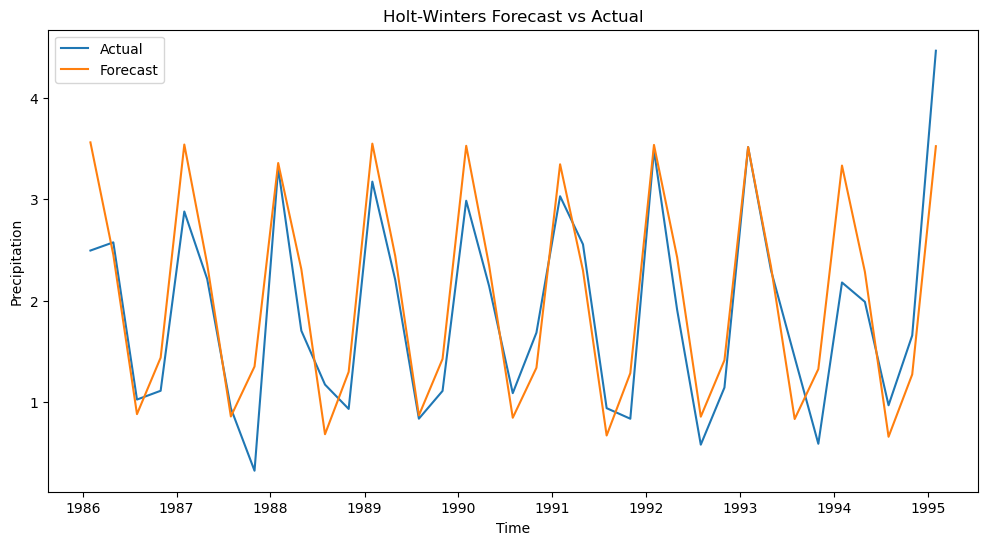

In [418]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['precipitation_diff'], label='Actual')

# Plot the forecasted values
plt.plot(test.index, forecast, label='Forecast')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('Holt-Winters Forecast vs Actual')
plt.legend()
plt.show()

In [480]:
df_VAR= df_clusters.copy()

In [481]:
df_VAR = pd.merge(df_VAR, df_flatten[['time', 'lat', 'lon']], on='time', how='left')

In [482]:
df_VAR

time  location_cluster  precipitation        lat      lon
0        1949-01-01                 0      18.044030  49.760941 -125.625
1        1949-01-01                 0      18.044030  49.760941 -125.000
2        1949-01-01                 0      18.044030  49.760941 -124.375
3        1949-01-01                 0      18.044030  49.760941 -123.750
4        1949-01-01                 0      18.044030  49.760941 -123.125
...             ...               ...            ...        ...      ...
13709611 1994-12-31                 2       0.019737  42.142059 -118.750
13709612 1994-12-31                 2       0.019737  42.142059 -118.125
13709613 1994-12-31                 2       0.019737  42.142059 -117.500
13709614 1994-12-31                 2       0.019737  42.142059 -116.875
13709615 1994-12-31                 2       0.019737  42.142059 -116.250

[13709616 rows x 5 columns]

In [483]:
df_VAR.set_index('time', inplace=True)

# Resample to month intervals to represent seasons
seasonal_VAR = df_VAR.groupby('location_cluster')['precipitation'].resample('3M').mean()

# Reset index to have 'time' as a column
seasonal_VAR = seasonal_VAR.reset_index()

seasonal_VAR = derive_temporal_features(seasonal_VAR)

In [484]:
seasonal_VAR 

location_cluster       time  precipitation  year  month  day  \
0                   0 1949-01-31       2.314278  1949      1   31   
1                   0 1949-04-30       8.156481  1949      4   30   
2                   0 1949-07-31       1.804433  1949      7   31   
3                   0 1949-10-31       2.782609  1949     10   31   
4                   0 1950-01-31      12.139178  1950      1   31   
..                ...        ...            ...   ...    ...  ...   
550                 2 1994-01-31       2.864145  1994      1   31   
551                 2 1994-04-30       2.518007  1994      4   30   
552                 2 1994-07-31       1.322154  1994      7   31   
553                 2 1994-10-31       1.716276  1994     10   31   
554                 2 1995-01-31       5.224979  1995      1   31   

     week_of_year  day_of_week  day_of_year  quarter  month_cos  \
0               5            0           31        1   0.866025   
1              17            5          120        2  -0.500000   
2              30            6          212        3  -0.866025   
3              44            0          304        4   0.500000   
4               5            1           31        1   0.866025   
..            ...          ...          ...      ...        ...   
550             5            0           31        1   0.866025   
551            17            5          120        2  -0.500000   
552            30            6          212        3  -0.866025   
553            44            0          304        4   0.500000   
554             5            1           31        1   0.866025   

     day_of_week_cos  
0           1.000000  
1          -0.222521  
2           0.623490  
3           1.000000  
4           0.623490  
..               ...  
550         1.000000  
551        -0.222521  
552         0.623490  
553         1.000000  
554         0.623490  

[555 rows x 12 columns]

### NOT TIME SERIES MODEL (Single cluster)

Functions

In [485]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [575]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [722]:
def plot_model_scores(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    
    # Print RMSE
    # print(f'Train Score ({model_name}): {trainScore:.2f} RMSE')
    # print(f'Test Score ({model_name}): {testScore:.2f} RMSE')

    # Plot RMSE
    plt.figure(figsize=(6, 4))
    plt.bar(['Training', 'Testing'], [trainScore, testScore], color=['blue', 'orange'])
    plt.title(f'RMSE Comparison ({model_name})')
    plt.ylabel('RMSE')
    plt.ylim(0, max(trainScore, testScore) * 1.2)
    plt.show()

    return trainScore, testScore

In [710]:
def calc_residuals(observed, predicted):
    """
    Calculate residuals given observed and predicted values.

    Args:
    - observed (list or numpy array): The observed values.
    - predicted (list or numpy array): The predicted values.

    Returns:
    - residuals (numpy array): The residuals.
    """
    import numpy as np

    observed = np.array(observed)
    predicted = np.array(predicted)
    residuals = observed - predicted

    return residuals

In [711]:
def plot_sampled_predictions(model_name, y_test, y_pred, sample_size, plot_residuals_line=True):
    # Sample the indices from y_pred
    sample_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
    y_test_sampled = y_test.iloc[sample_indices]
    y_pred_sampled = y_pred[sample_indices]
    residuals_sampled = y_pred_sampled - y_test_sampled

    # Calculate average residual
    avg_residual = residuals_sampled.mean()

    # Plot the sampled actual values and predicted values with lines connecting them
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_sampled.index, y_test_sampled, color='blue', label='Observed', alpha=0.6)
    plt.scatter(y_test_sampled.index, y_pred_sampled, color='red', label='Predicted', alpha=0.6)
    if plot_residuals_line:
        for i in range(sample_size):
            plt.plot([y_test_sampled.index[i], y_test_sampled.index[i]], [y_test_sampled.iloc[i], y_pred_sampled[i]], color='black', linestyle='-', linewidth=1)
        plt.text(y_test_sampled.index.min(), avg_residual, f'Avg Residual: {avg_residual:.2f}', ha='left', va='center', backgroundcolor='white')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.title(f'{sample_size} Sampled Observed vs Predicted Precipitation ({model_name})')
    plt.legend()
    plt.show()

In [712]:
# Function to plot learning curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23000\121861753.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = seasonal_VAR.corr()


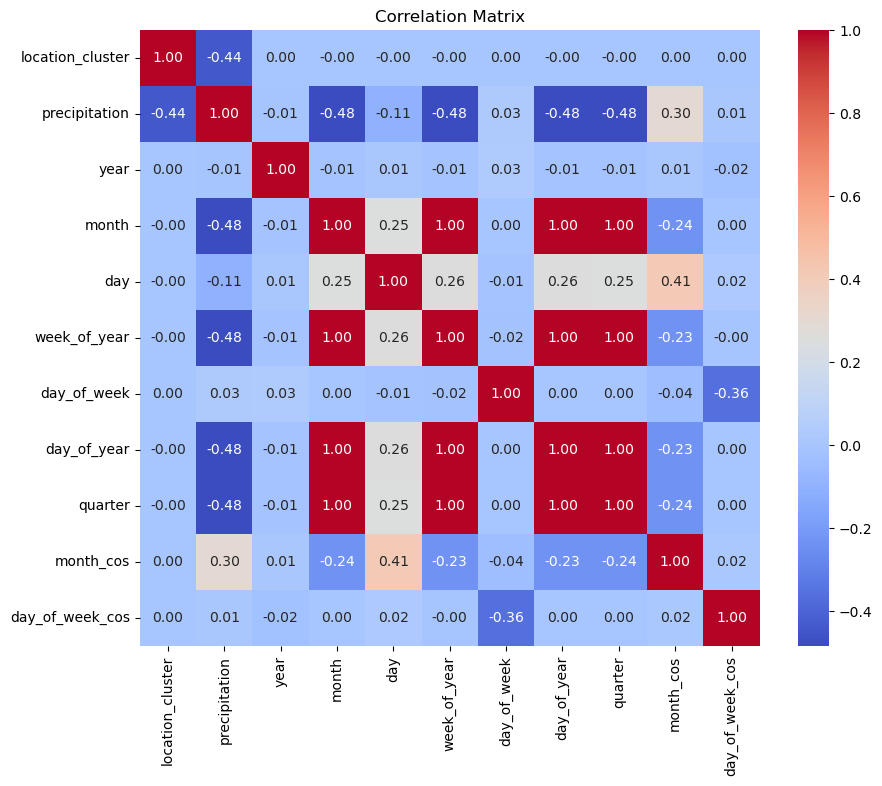

In [516]:
# Compute the correlation matrix
corr = seasonal_VAR.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

### Linear Regression 

In [713]:
from sklearn.linear_model import LinearRegression

X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
y = seasonal_VAR['precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Get coefficients
coefficients = linear_model.coef_
feature_names = X.columns

# feature importance
for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')

location_cluster: -1.5488639057104518
month_cos: 1.122892138727688
year: -0.010949187724499728
day_of_year: -0.3416003079585141
quarter: 32.32487255159919
week_of_year: -0.17544424457552402
day_of_week_cos: -0.022288206892742583


In [714]:
y_pred = linear_model.predict(X_test)

rmse, mae, r2 = evaluate_model(y_pred, y_test)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 2.332558661130431
MAE: 1.8780372182118212
R-squared: -0.31701060104425616


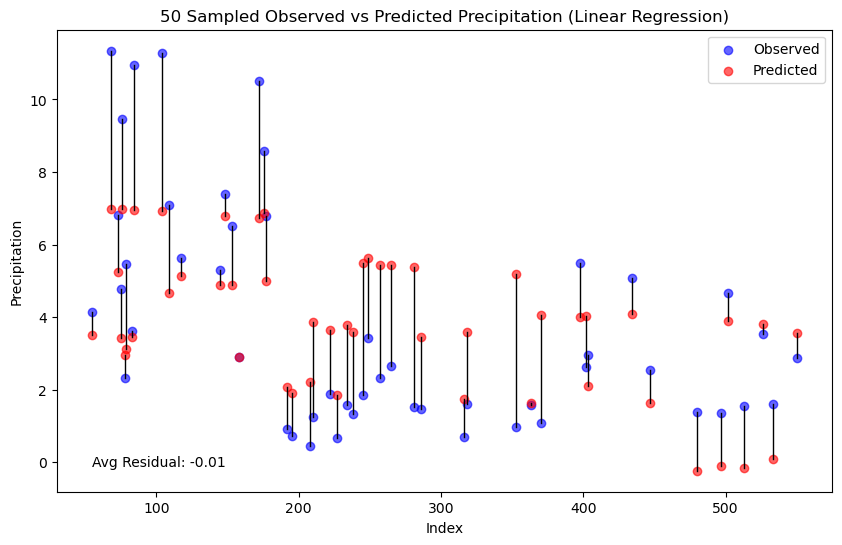

In [715]:
plot_sampled_predictions("Linear Regression", y_test, y_pred, 50)

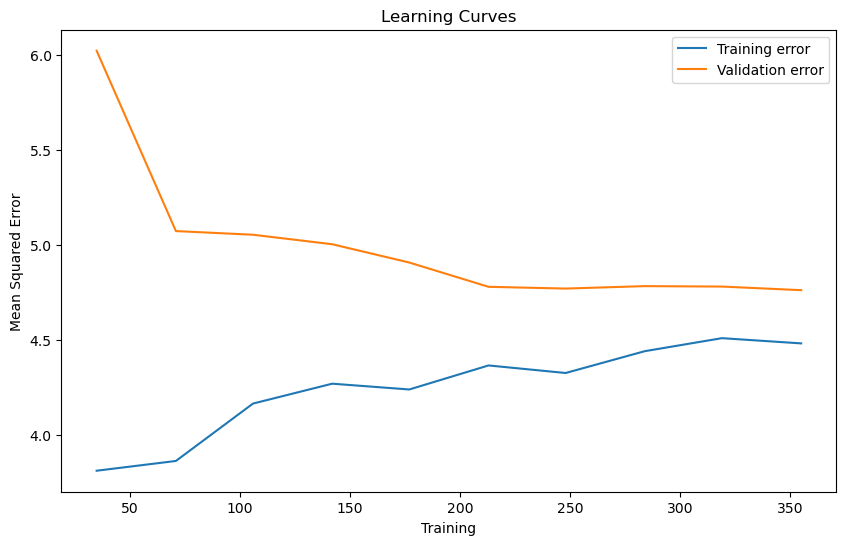

In [716]:
plot_learning_curves(linear_model, X_train, y_train)

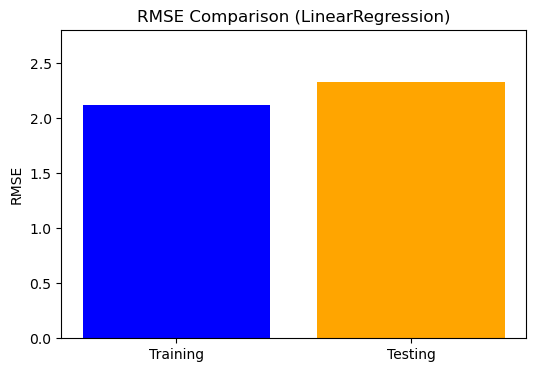

In [723]:
train_score, test_score = plot_model_scores(linear_model, X_train, y_train, X_test, y_test, 'LinearRegression')

### Random Forest

In [724]:
from sklearn.ensemble import RandomForestRegressor

In [725]:
seasonal_VAR 

location_cluster       time  precipitation  year  month  day  \
0                   0 1949-01-31       2.314278  1949      1   31   
1                   0 1949-04-30       8.156481  1949      4   30   
2                   0 1949-07-31       1.804433  1949      7   31   
3                   0 1949-10-31       2.782609  1949     10   31   
4                   0 1950-01-31      12.139178  1950      1   31   
..                ...        ...            ...   ...    ...  ...   
550                 2 1994-01-31       2.864145  1994      1   31   
551                 2 1994-04-30       2.518007  1994      4   30   
552                 2 1994-07-31       1.322154  1994      7   31   
553                 2 1994-10-31       1.716276  1994     10   31   
554                 2 1995-01-31       5.224979  1995      1   31   

     week_of_year  day_of_week  day_of_year  quarter  month_cos  \
0               5            0           31        1   0.866025   
1              17            5          120        2  -0.500000   
2              30            6          212        3  -0.866025   
3              44            0          304        4   0.500000   
4               5            1           31        1   0.866025   
..            ...          ...          ...      ...        ...   
550             5            0           31        1   0.866025   
551            17            5          120        2  -0.500000   
552            30            6          212        3  -0.866025   
553            44            0          304        4   0.500000   
554             5            1           31        1   0.866025   

     day_of_week_cos  
0           1.000000  
1          -0.222521  
2           0.623490  
3           1.000000  
4           0.623490  
..               ...  
550         1.000000  
551        -0.222521  
552         0.623490  
553         1.000000  
554         0.623490  

[555 rows x 12 columns]

In [726]:
# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X = seasonal_VAR[['location_cluster', 'month_cos']]
y = seasonal_VAR['precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [727]:
from sklearn.pipeline import make_pipeline

In [728]:
forest = RandomForestRegressor(random_state=42)

pipeline = make_pipeline(forest)

In [729]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [730]:
# Evaluate the model
y_pred = pipeline.predict(X_test)

rmse, mae, r2 = evaluate_model(y_pred, y_test)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1.297331514685382
MAE: 0.7944731432120163
R-squared: 0.8096719157776786


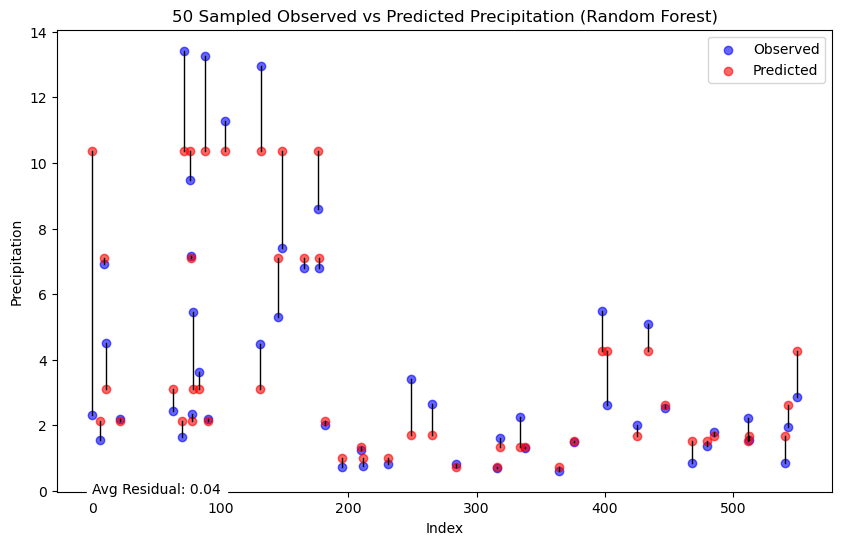

In [731]:
plot_sampled_predictions("Random Forest", y_test, y_pred, 50)

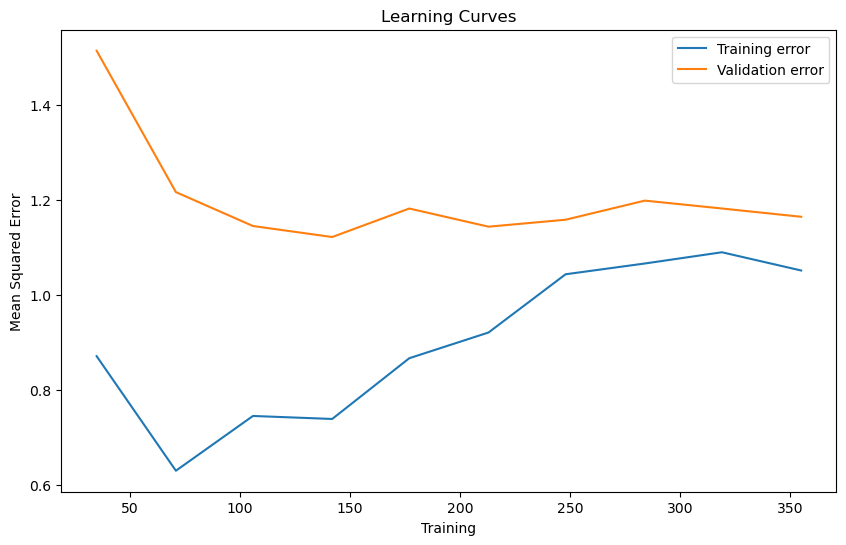

In [732]:
plot_learning_curves(forest, X_train, y_train)

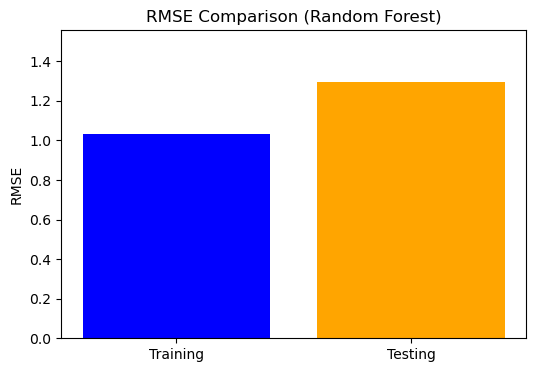

In [735]:
train_score, test_score = plot_model_scores(forest, X_train, y_train, X_test, y_test, 'Random Forest')

### XGBoost

In [736]:
from xgboost import XGBRegressor

# X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
X = seasonal_VAR[['location_cluster', 'month_cos']]
y = seasonal_VAR['precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_boost = XGBRegressor()
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [738]:
# Make predictions
y_pred = xg_boost.predict(X_test)

# Evaluate the model
rmse, mae, r2 = evaluate_model(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1.2956138386927651
MAE: 0.7891737714794977
R-squared: 0.8359415612990504


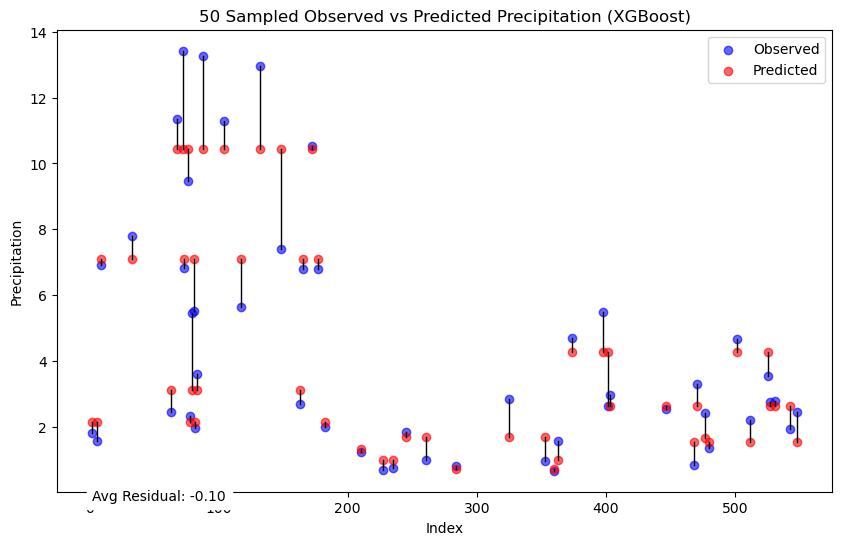

In [739]:
plot_sampled_predictions("XGBoost", y_test, y_pred, 50)

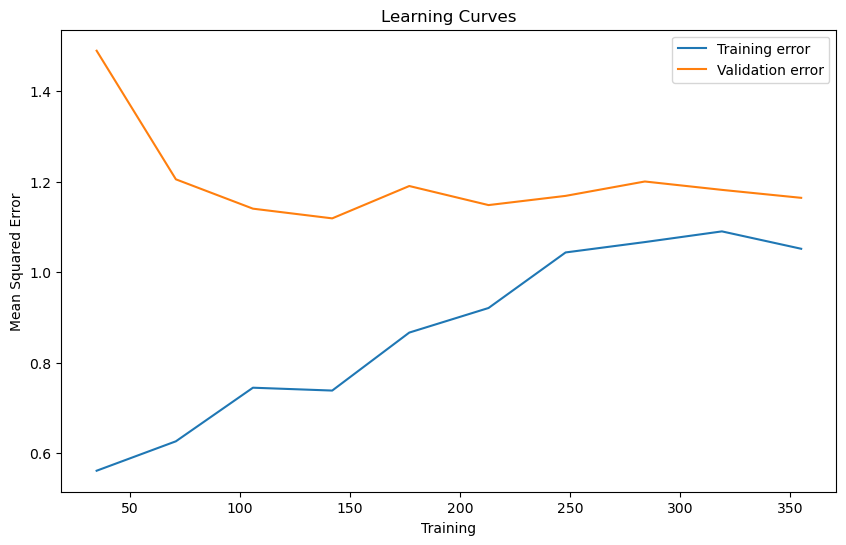

In [740]:
plot_learning_curves(xg_boost, X_train, y_train)

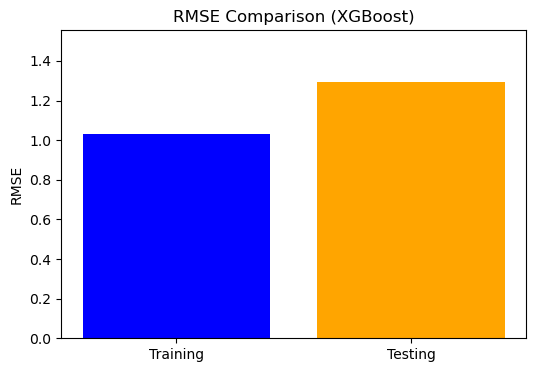

In [741]:
train_score, test_score = plot_model_scores(xg_boost, X_train, y_train, X_test, y_test, 'XGBoost')

### LSTM

In [666]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [668]:
X = seasonal_VAR[['location_cluster', 'month_cos', 'year', 'day_of_year', 'quarter', 'week_of_year', 'day_of_week_cos']]
# X = seasonal_VAR[['location_cluster', 'month_cos']]
y = seasonal_VAR['precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [669]:
# Reshape the data for LSTM input
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - loss: 16.9354 
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8745 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.3361 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 14.8340
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 18.6328
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 13.1745
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.8399 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 10.0159
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 10.4382
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 9.7971
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6643 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9194 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2696 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5998  
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.546

In [670]:
y_pred = lstm_model.predict(X_test_reshaped)

rmse, mae, r2 = evaluate_model(y_pred, y_test)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
RMSE: 1.810884241725751
MAE: 1.3874689345817586
R-squared: 0.37825873114486297


### Time Series for Each Cluster

In [781]:
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided.*")

In [764]:
from sklearn.model_selection import TimeSeriesSplit

In [766]:
tscv = TimeSeriesSplit(n_splits=5)

In [773]:
def evaluate_time_series(test, forecast, model):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    # print(f"{model}: RMSE = {rmse}, MAE = {mae}, R-squared = {r2}")

    return rmse, mae, r2

In [845]:
def plot_avg_actual_vs_forecast(avg_actual, avg_forecast, cluster_label):
    start_index = np.argmax(avg_actual != 0)
    plt.figure(figsize=(12, 6))
    plt.plot(avg_actual[start_index:], label='Average Actual')
    plt.plot(avg_forecast[start_index:], label='Average Forecast')
    plt.title(f"Cluster {cluster_label}: Average Actual vs Forecast")
    plt.legend()
    plt.show()

In [813]:
from pathlib import Path

def update_results_csv(cluster_label, model_name, best_params, metrics, best_metric_score, results_csv_path='parameter_tuning_time_series_results.csv'):
    if not Path(results_csv_path).is_file():
        results_df = pd.DataFrame(columns=['Cluster', 'Model', 'Best Parameters', 'Metrics', 'Best Metric Score'])
    else:
        results_df = pd.read_csv(results_csv_path)
        
    new_row = {'Cluster': cluster_label,
               'Model': model_name,
               'Best Parameters': best_params,
               'Metrics': metrics,
               'Best Metric Score': best_metric_score}
    
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    
    results_df.to_csv(results_csv_path, index=False)

Prepare data

In [762]:
processed_cluster_data = process_all_clusters(df_clusters)

In [763]:
processed_cluster_data

precipitation  location_cluster
time                                       
1949-01-31       2.314321                 0
1949-04-30       8.156552                 0
1949-07-31       1.804433                 0
1949-10-31       2.782609                 0
1950-01-31      12.139178                 0
...                   ...               ...
1994-01-31       2.864145                 2
1994-04-30       2.518007                 2
1994-07-31       1.322154                 2
1994-10-31       1.716276                 2
1995-01-31       5.224979                 2

[555 rows x 2 columns]

ARIMA

In [776]:
df_clusters_ARIMA = processed_cluster_data
target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_ARIMA.columns else 'precipitation'

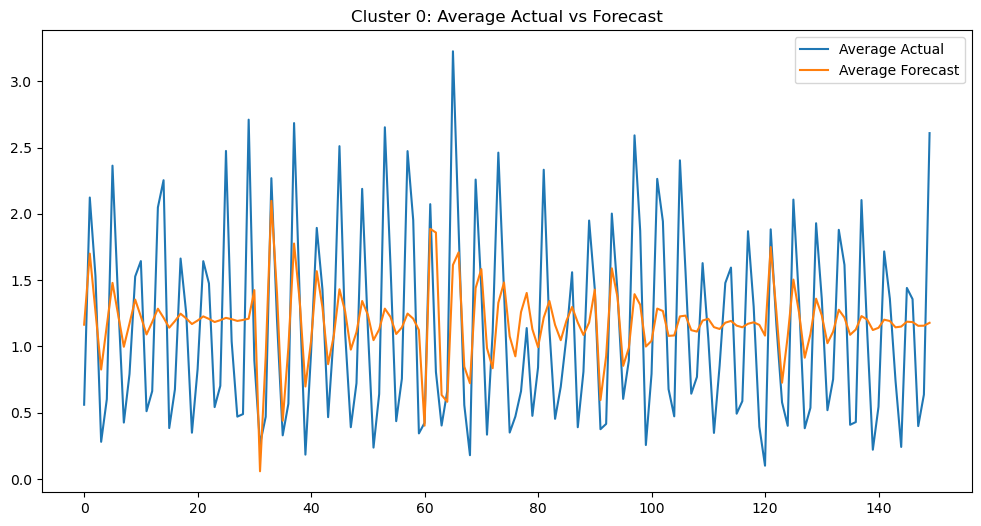

Cluster 0: Average RMSE = 3.036440562125856, Average MAE = 2.530883702180953, Average R-squared = 0.29566327248211866 



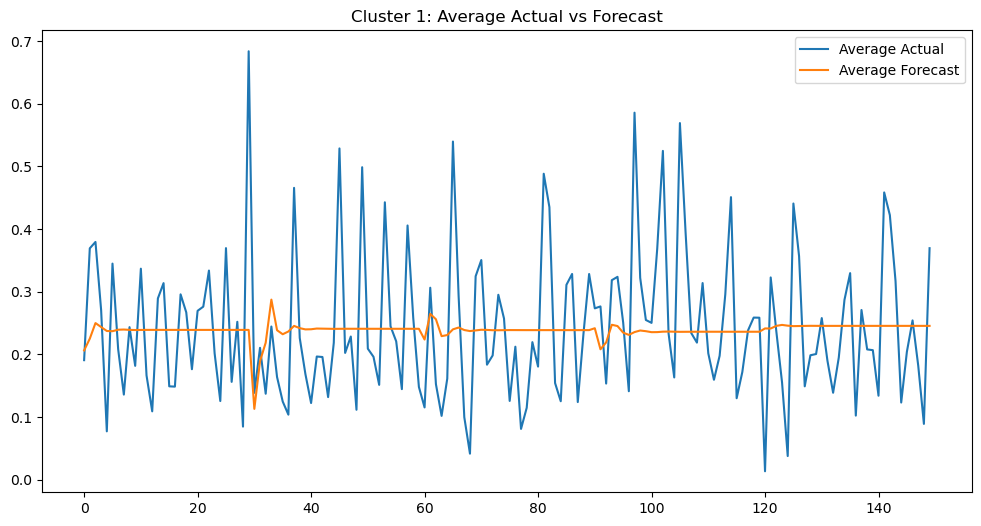

Cluster 1: Average RMSE = 0.593621587355773, Average MAE = 0.4575616164348917, Average R-squared = -0.027250797342260567 



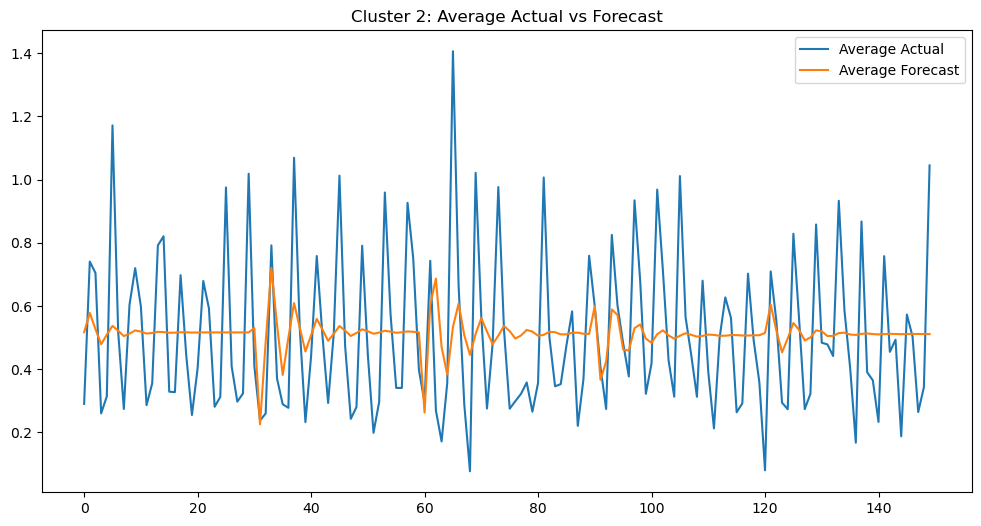

Cluster 2: Average RMSE = 1.1988730791889464, Average MAE = 0.9567599423994855, Average R-squared = 0.08929033219044355 



In [800]:
from statsmodels.tsa.arima.model import ARIMA

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    # Iterate over each fold of the time series cross-validation
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit ARIMA model
        order = (3, 0, 0)
        model = ARIMA(train[target], order=order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"ARIMA{order}")

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label)

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}, Average MAE = {avg_mae}, Average R-squared = {avg_r2} \n")

Hyperparameters Tuning ARIMA

In [829]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Define the ranges for the parameters
p = range(0, 3) # AR orders
d = range(0, 3) # Differencing order (I)
q = range(1, 3) # MA orders

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q))

Tuning (AIC)

In [827]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_aic = float("inf")
    best_order = None

    for param in param_combinations:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
            warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
            warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
            try:
                # Fit ARIMA model
                model = ARIMA(cluster_data[target], order=param)
                model_fit = model.fit()

                # Calculate AIC (Akaike Information Criterion)
                aic = model_fit.aic

                # Update best parameters if current model has lower AIC
                if aic < best_aic:
                    best_aic = aic
                    best_order = param

            except Exception as e:
                print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA', best_order, 'AIC', best_aic)

Cluster 0:
  Best ARIMA order: (2, 0, 2)
Cluster 1:
  Best ARIMA order: (4, 0, 2)
Cluster 2:
  Best ARIMA order: (4, 0, 2)


Tuning ARIMA (RMSE)

In [830]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None

    for param in param_combinations:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
            warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
            warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
            try:
                model = ARIMA(cluster_data[target], order=param)
                model_fit = model.fit()

                # Make predictions
                predictions = model_fit.forecast(len(cluster_data))  # Forecast entire series

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(cluster_data[target], predictions))

                # Update best parameters if current model has lower RMSE
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = param

            except Exception as e:
                print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    print(f"Cluster {cluster_label}:")
    print("  Best ARIMA order:", best_order)

    # Update results CSV
    update_results_csv(cluster_label, 'ARIMA', best_order, 'RMSE', best_rmse)

Cluster 0:
  Best ARIMA order: (0, 0, 1)
Cluster 1:
  Best ARIMA order: (0, 0, 1)
Cluster 2:
  Best ARIMA order: (0, 0, 1)


SARIMA

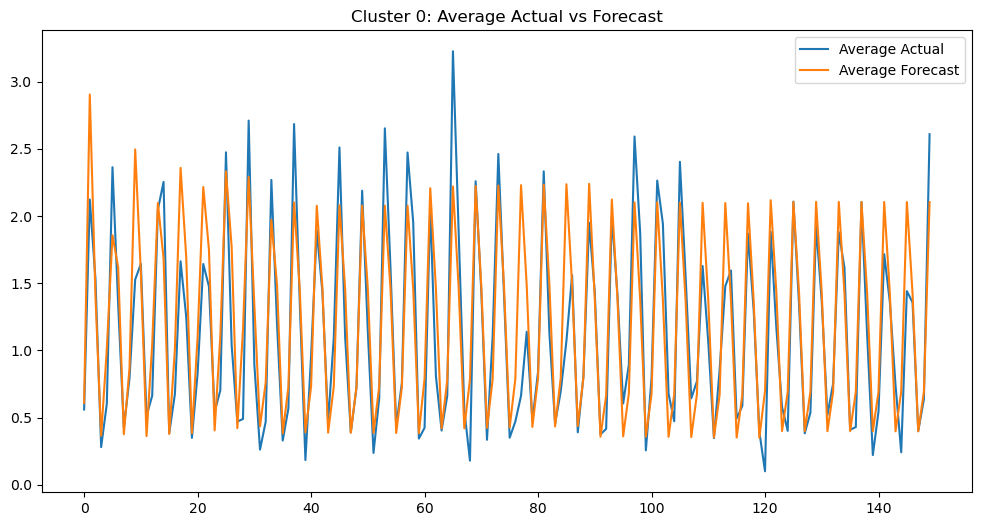

Cluster 0: Average RMSE = 1.710310017198724, Average MAE = 1.2647052475549976, Average R-squared = 0.7687116923928233 



c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\User\Desktop\text-generation-webui-main\installer_files\conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


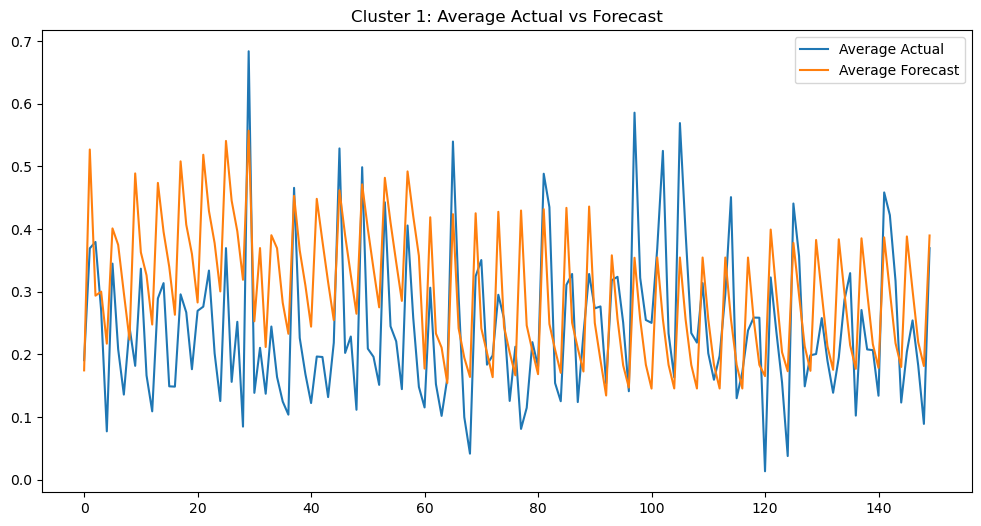

Cluster 1: Average RMSE = 0.6079473237779356, Average MAE = 0.5153630996407704, Average R-squared = -0.11833176693452763 



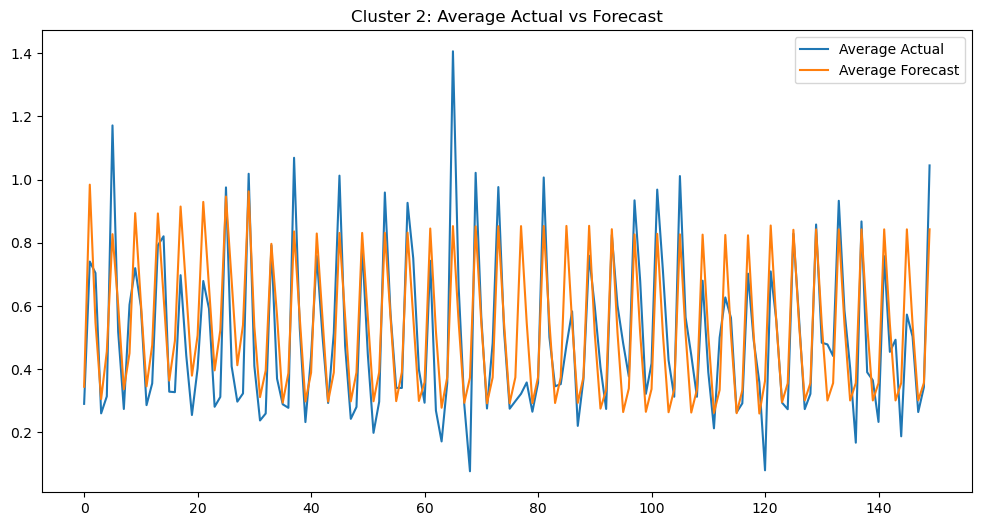

Cluster 2: Average RMSE = 0.6961284218483625, Average MAE = 0.5457268884239415, Average R-squared = 0.688898515644621 



In [803]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Iterate over each cluster
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    # Iterate over each fold of the time series cross-validation
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit SARIMA model
        order = (1, 1, 1)
        seasonal_order = (1, 1, 1, 4)
        model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        # Evaluate
        rmse, mae, r2 = evaluate_time_series(test[target], forecast, f"SARIMA{order}")

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label)

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}, Average MAE = {avg_mae}, Average R-squared = {avg_r2} \n")

Hyperparameters Tuning SARIMA

In [831]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ranges for the parameters
d = range(1, 3) # I
p = q = range(1, 3)  # AR, MA
P = D = Q = range(0, 2)  # Seasonal AR, I, MA
s = 4  # Seasonal period (quarterly seasonality)

# Create a list of all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q))

In [ ]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):

    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    for param in param_combinations:
        # Unpack the seasonal order
        seasonal_order = param[3:6]  # (P, D, Q)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
            warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
            warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
            
            try:
                # Fit SARIMA model
                model = SARIMAX(cluster_data[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                model_fit = model.fit()

                # Calculate AIC (Akaike Information Criterion)
                aic = model_fit.aic

                # Update best parameters if current model has lower AIC
                if aic < best_aic:
                    best_aic = aic
                    best_order = param[:3]
                    best_seasonal_order = seasonal_order

            except Exception as e:
                print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")


    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA', best_order + best_seasonal_order + (s,), 'AIC', best_aic)

In [833]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_order = None
    best_seasonal_order = None

    for param in param_combinations:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
            warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
            warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")
            try:
                # Fit SARIMA model
                model = SARIMAX(cluster_data[target], order=param[:3], seasonal_order=seasonal_order + (s,))
                model_fit = model.fit()

                # Make predictions
                predictions = model_fit.forecast(len(cluster_data))  # Forecast entire series

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(cluster_data[target], predictions))

                # Update best parameters if current model has lower RMSE
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = param[:3]
                    best_seasonal_order = seasonal_order

            except Exception as e:
                print(f"Error fitting model for parameters {param} in cluster {cluster_label}: {e}")

    print(f"Cluster {cluster_label}:")
    print("  Best SARIMA order:", best_order)
    print("  Best SARIMA seasonal order:", best_seasonal_order)

    # Update results CSV
    update_results_csv(cluster_label, 'SARIMA', best_order + best_seasonal_order + (s,), 'RMSE', best_rmse)

Cluster 0:
  Best SARIMA order: (2, 1, 2)
  Best SARIMA seasonal order: (1, 1, 1)
Cluster 1:
  Best SARIMA order: (2, 1, 1)
  Best SARIMA seasonal order: (1, 1, 1)
Cluster 2:
  Best SARIMA order: (2, 1, 2)
  Best SARIMA seasonal order: (1, 1, 1)


HOLT WINTER

In [843]:
# Exponential Smoothing
df_clusters_ES= processed_cluster_data 
target = 'precipitation_diff' if 'precipitation_diff' in df_clusters_ES.columns else 'precipitation'

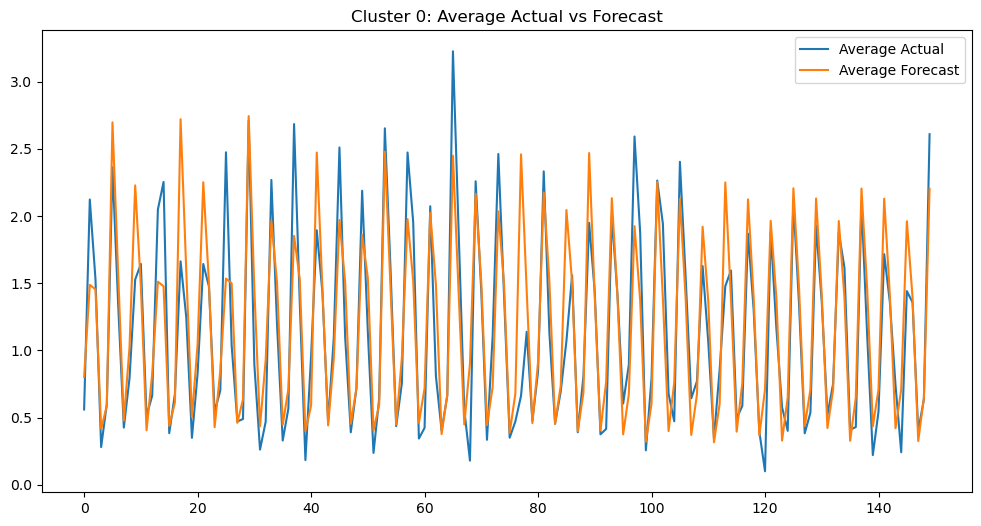

Cluster 0: Average RMSE = 1.7746384222930967, Average MAE = 1.28529584823182, Average R-squared = 0.7547874757961849 



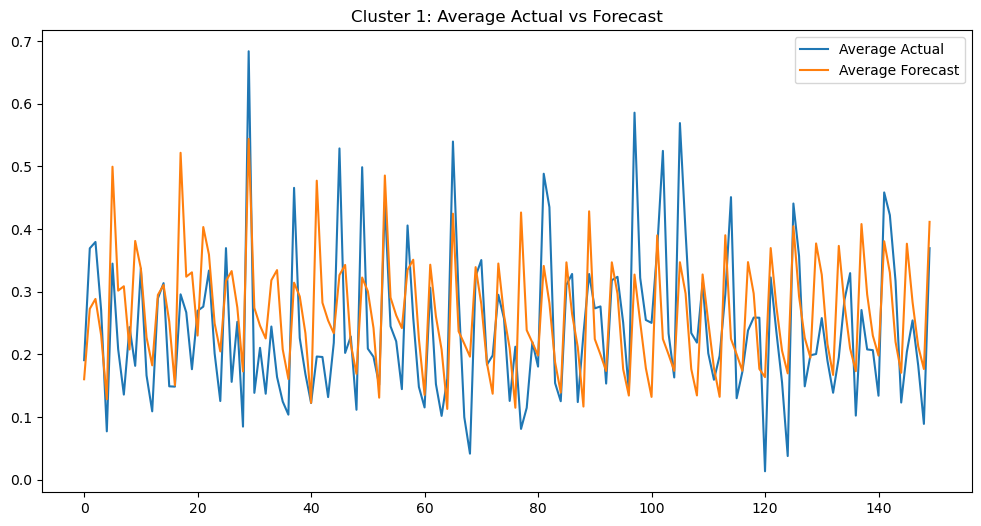

Cluster 1: Average RMSE = 0.5138525078534183, Average MAE = 0.4050445809661759, Average R-squared = 0.2300806150134452 



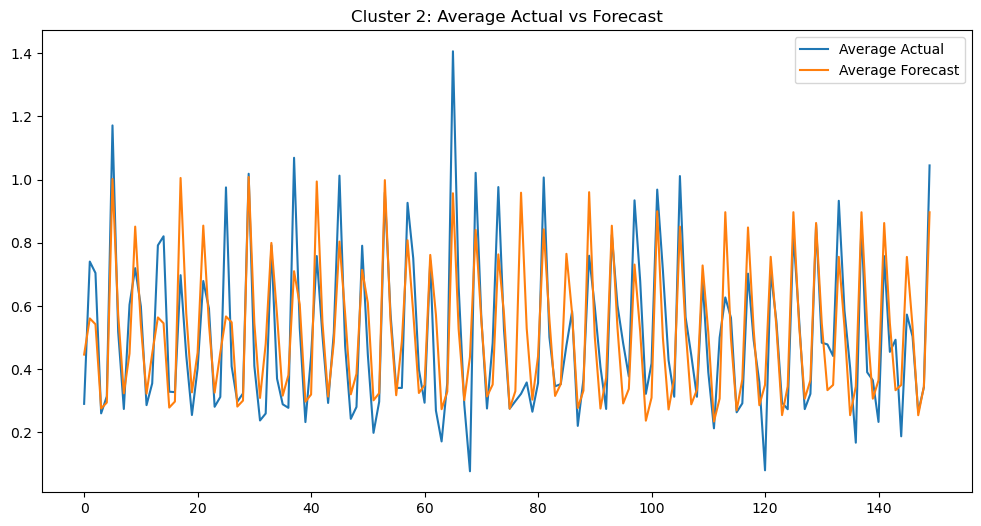

Cluster 2: Average RMSE = 0.7151272519850125, Average MAE = 0.5457328002779731, Average R-squared = 0.6751781732977126 



In [846]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):

    avg_rmse_values = []
    avg_mae_values = []
    avg_r2_values = []
    avg_actual_values = np.zeros(len(cluster_data))
    avg_forecast_values = np.zeros(len(cluster_data))
    fold_count = 0

    # Iterate over each fold of the time series cross-validation
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]

        # Fit Holt-Winters model
        model = ExponentialSmoothing(train[target], trend='add',seasonal='add', seasonal_periods=12)
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(len(test))

        # Evaluate
        rmse = np.sqrt(mean_squared_error(test[target], forecast))
        mae = mean_absolute_error(test[target], forecast)
        r2 = r2_score(test[target], forecast)

        # Accumulate evaluation metrics
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

        # Accumulate actual and forecast values for averaging
        avg_actual_values[test_index] += test[target].values
        avg_forecast_values[test_index] += forecast
        fold_count += 1

    # Average actual and forecast values
    avg_actual_values /= fold_count
    avg_forecast_values /= fold_count

    # Plot average actual vs forecast
    plot_avg_actual_vs_forecast(avg_actual_values, avg_forecast_values, cluster_label)

    # Calculate and print average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Cluster {cluster_label}: Average RMSE = {avg_rmse}, Average MAE = {avg_mae}, Average R-squared = {avg_r2} \n")

HOLT WINTER Hyperparameters Tuning

In [849]:
# Function to evaluate Holt-Winters model with given hyperparameters
def evaluate_holt_winters(train, test, trend, seasonal, seasonal_period):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
    model_fit = model.fit()
    forecast = model_fit.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    return rmse, mae, r2

In [848]:
trend_types = ['add', 'mul']
seasonal_types = ['add', 'mul']
seasonal_periods = [4, 12]  # Quarterly and monthly seasonality

# tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
for cluster_label, cluster_data in df_clusters_ARIMA.groupby('location_cluster'):
    best_rmse = float("inf")
    best_trend = None
    best_seasonal = None
    best_seasonal_period = None

    # Iterate over hyperparameters
    for trend in trend_types:
        for seasonal in seasonal_types:
            for period in seasonal_periods:
                avg_rmse_values = []
                for train_index, test_index in tscv.split(cluster_data):
                    train, test = cluster_data.iloc[train_index][target], cluster_data.iloc[test_index][target]
                    rmse, _, _ = evaluate_holt_winters(train, test, trend, seasonal, period)
                    avg_rmse_values.append(rmse)
                avg_rmse = np.mean(avg_rmse_values)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_trend = trend
                    best_seasonal = seasonal
                    best_seasonal_period = period

    print(f"Cluster {cluster_label}: Best RMSE = {best_rmse}, Trend = {best_trend}, Seasonal = {best_seasonal}, Seasonal Period = {best_seasonal_period}")

    update_results_csv(cluster_label, 'Holt-Winters', f'Best Trend = {best_trend}, Best Seasonal = {best_seasonal}', 'RMSE', best_rmse)

Gradient Boosting

In [326]:
df_clusters_GB = df_flat[['precipitation', 'location_cluster', 'month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']]

In [335]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize lists to store evaluation metrics
avg_rmse_values = []
avg_mae_values = []
avg_r2_values = []

# Group by location_cluster and iterate over each cluster
for cluster_label, cluster_data in df_clusters_GB.groupby('location_cluster'):
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        
        # Define features and target variable
        X_train, y_train = train[['month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']], train['precipitation']
        X_test, y_test = test[['month', 'year', 'day_of_year', 'week_of_year', 'day_of_week']], test['precipitation']
        
        # Initialize and train the model
        model = GradientBoostingRegressor()
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        rmse, mae, r2 = evaluate_model(y_test, y_pred)
        avg_rmse_values.append(rmse)
        avg_mae_values.append(mae)
        avg_r2_values.append(r2)

    # Calculate average evaluation metrics
    avg_rmse = np.mean(avg_rmse_values)
    avg_mae = np.mean(avg_mae_values)
    avg_r2 = np.mean(avg_r2_values)

    print(f"Average RMSE: {avg_rmse}")
    print(f"Average MAE: {avg_mae}")
    print(f"Average R-squared: {avg_r2}")

Average RMSE: 7.354634761460628
Average MAE: 3.595998177074441
Average R-squared: 0.018934931601446124
Average RMSE: 5.431866498172717
Average MAE: 2.7413716435280753
Average R-squared: -0.01670153540582602
Average RMSE: 5.303933239789765
Average MAE: 2.5902619405742096
Average R-squared: -0.00739257094405971
